### Udacity Data Science Nanodegree
### Project 3: Disaster Recovery Pipeline
---

# Notebook 3 of 3: ML Pipeline Preparation

## by Juanita Smith
---

Table of contents:
- [1. Import libraries and load data from database](#step1)
- [2. Write a tokenization function to process text data](#step2)
- [3. Build a machine learning pipeline using `XGBOOST`](#step3)
- [4. Set a baseline - Train and evaluate pipeline](#step4)
- [5. Improve the model with `GridSearchCV` and `Optuna`](#step5)
- [6. Further improve the model](#step6)
    - [Add `starting_verb` feature](#step62)
    - [Use `OpenAI` to create embeddings instead of using tokenizer](#step63)
- [7. Final model performance](#step7)
- [8. Export final model as a pickle file](#step8)
- [References](#ref)



<a class="anchor" id='step1'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">1. Import libraries and load data from database</span>

In [1]:
import nltk
import numpy as np

nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# import libraries

from sqlalchemy import create_engine
import os

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
from shutil import rmtree

# save and load models
from pickle import dump, load

# clear the garbage to free memory as we are working with huge datasets
import gc

from openai import OpenAI
import tiktoken
from typing import List
from ast import literal_eval

# CUSTOM methods and functions
from src.startingverbtransformer import StartingVerbExtractor
from src.mloversampler import MLOverSampling
from src.focalloss import FocalBinaryLoss
from src.utils import *
from src import config

import optuna.logging
from optuna.samplers import TPESampler
import logging

# environment settings
pd.set_option('display.max_column', 400)
pd.set_option('display.max_colwidth', 400)
pd.set_option("display.precision", 300)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# default parameters
random_state = 10
logger = logging.getLogger(__name__)

# activate logging
logging.basicConfig(filename=config.path_log_ml_prep,
                    format='%(asctime)s %(levelname)-8s %(message)s',
                    filemode='w',
                    level=logging.INFO,
                    datefmt='%Y-%m-%d %H:%M:%S')

In [4]:
# load cleaned message data from database
engine = create_engine(config.path_database)
conn = engine.connect()
df = pd.read_sql('select * from messages', con=conn, index_col='id')
df.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   message                 26179 non-null  object
 1   genre                   26179 non-null  object
 2   related                 26179 non-null  int64 
 3   request                 26179 non-null  int64 
 4   offer                   26179 non-null  int64 
 5   aid_related             26179 non-null  int64 
 6   medical_help            26179 non-null  int64 
 7   medical_products        26179 non-null  int64 
 8   search_and_rescue       26179 non-null  int64 
 9   security                26179 non-null  int64 
 10  military                26179 non-null  int64 
 11  water                   26179 non-null  int64 
 12  food                    26179 non-null  int64 
 13  shelter                 26179 non-null  int64 
 14  clothing                26179 non-null  int64 
 15  money  

In [6]:
# sqlite does not keep data types int8 or category as it's not supported, set it again
df["genre"] = df["genre"].astype("category")
d = dict.fromkeys(df.select_dtypes(np.int64).columns, np.int8)
df = df.astype(d)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   message                 26179 non-null  object  
 1   genre                   26179 non-null  category
 2   related                 26179 non-null  int8    
 3   request                 26179 non-null  int8    
 4   offer                   26179 non-null  int8    
 5   aid_related             26179 non-null  int8    
 6   medical_help            26179 non-null  int8    
 7   medical_products        26179 non-null  int8    
 8   search_and_rescue       26179 non-null  int8    
 9   security                26179 non-null  int8    
 10  military                26179 non-null  int8    
 11  water                   26179 non-null  int8    
 12  food                    26179 non-null  int8    
 13  shelter                 26179 non-null  int8    
 14  clothing                261

In [7]:
category_names = list(df.select_dtypes(np.int8).columns)
category_names

['related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

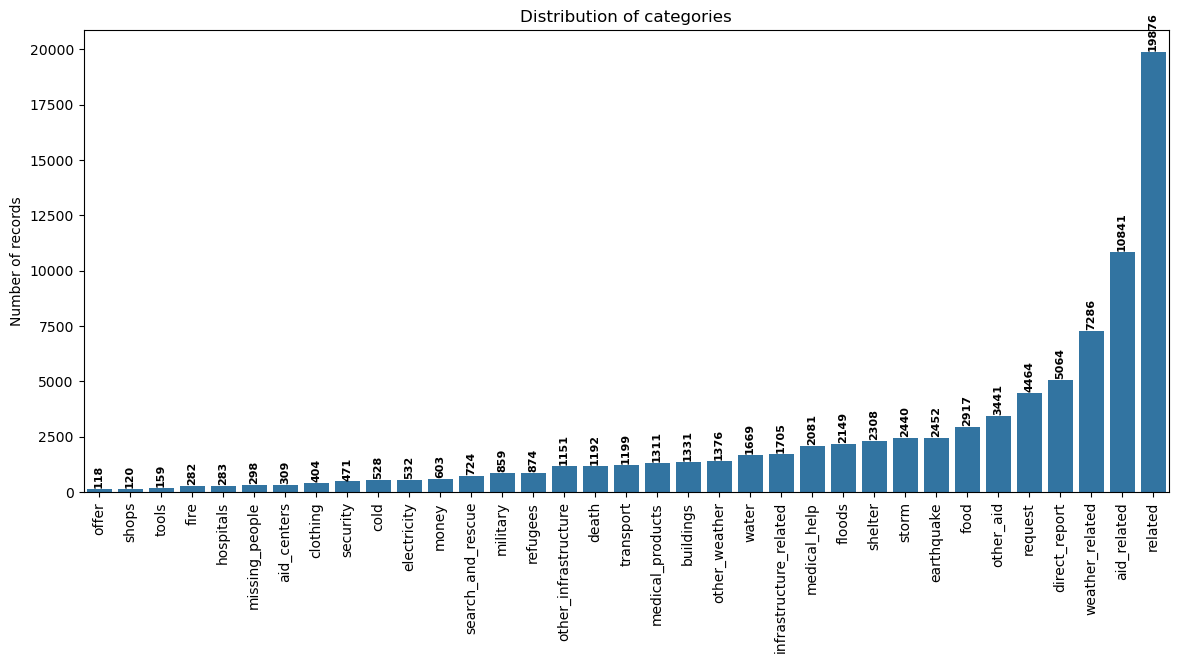

In [8]:
 # plot how categories are distributed
df_sum = df.sum(numeric_only=True).sort_values(ascending=True)
fig = plt.figure(figsize=(14,6))
ax = sns.barplot(data=df_sum)

# annotate
for c in ax.containers:
    # set the bar label based on the y-axis
    ax.bar_label(c, padding=1, fontsize=8, rotation=90, weight='bold')
        
plt.xticks(rotation=90)

plt.title('Distribution of categories')
plt.ylabel('Number of records')
plt.show()

In [9]:
# store the category imbalance sequence from low to high to make all plots in the project consistent
category_sequence = list(df_sum.index)
print(category_sequence)

['offer', 'shops', 'tools', 'fire', 'hospitals', 'missing_people', 'aid_centers', 'clothing', 'security', 'cold', 'electricity', 'money', 'search_and_rescue', 'military', 'refugees', 'other_infrastructure', 'death', 'transport', 'medical_products', 'buildings', 'other_weather', 'water', 'infrastructure_related', 'medical_help', 'floods', 'shelter', 'storm', 'earthquake', 'food', 'other_aid', 'request', 'direct_report', 'weather_related', 'aid_related', 'related']


In [10]:
# store the category imbalance sequence, with total score categories for plotting later on
score_index = category_sequence
for score in list(['micro avg', 'macro avg', 'weighted avg', 'samples avg']):
    category_sequence.append(score)
print(score_index)

['offer', 'shops', 'tools', 'fire', 'hospitals', 'missing_people', 'aid_centers', 'clothing', 'security', 'cold', 'electricity', 'money', 'search_and_rescue', 'military', 'refugees', 'other_infrastructure', 'death', 'transport', 'medical_products', 'buildings', 'other_weather', 'water', 'infrastructure_related', 'medical_help', 'floods', 'shelter', 'storm', 'earthquake', 'food', 'other_aid', 'request', 'direct_report', 'weather_related', 'aid_related', 'related', 'micro avg', 'macro avg', 'weighted avg', 'samples avg']


<a class="anchor" id='step2'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">2. Write a tokenization function to process text data</span>

Custom tokenizers was developed — see functions `tokenize` in `src/utils.py`

In [11]:
# testing tokenizer
test = df[(df['offer'] == 1)]
for message in test['message'][:3]:
    print(message)
    tokens_full = tokenize(message)
    tokens_basic = tokenizer_light(message)
    print(tokens_full)
    print(tokens_basic, '\n')

I am a driver, a mechanic ,. I want to help
['driver', 'mechanic', 'want', 'help']
I am a driver, a mechanic. I want to help 

How can we help the victims at Les Cayes?
['help', 'victims', 'les', 'cayes']
How can we help the victims at Les Cayes? 

I'm the vice president of the association Rafadek in Anse a galets. You can call me so that you could help people in La Gonave
['vice', 'president', 'association', 'rafadek', 'anse', 'galets', 'call', 'could', 'help', 'people', 'la', 'gonave']
I'm the vice president of the association Rafadek in Anse a galets. You can call me so that you could help people in La Gonave 



##### What is the impact of using ngram=(1,2) vs max_features?

In [12]:
# When using max_features 10,000 with ngram (1,2)
cv = CountVectorizer(tokenizer=tokenize,
                     token_pattern=None,
                     min_df=3,
                     max_df=0.95,
                     max_features=10000,
                     ngram_range=(1,2),
                     )

tokens = cv.fit_transform(df['message'])
feature_names = cv.get_feature_names_out()
freq = pd.DataFrame(tokens.toarray().sum(axis=0))
freq.columns = ['count']
freq.index = feature_names
freq = freq.sort_values(by='count', ascending=False)

In [13]:
# When using max_features 12,000 with ngram (1,2)
cv2 = CountVectorizer(tokenizer=tokenize,
                     token_pattern=None,
                     min_df=3,
                     max_df=0.95,
                     max_features=12000,
                     ngram_range=(1,2),
                     )

tokens2 = cv2.fit_transform(df['message'])
feature_names2 = cv2.get_feature_names_out()
freq2 = pd.DataFrame(tokens2.toarray().sum(axis=0))
freq2.columns = ['count']
freq2.index = feature_names2
freq2 = freq2.sort_values(by='count', ascending=False)

In [14]:
# what is the difference in word vocabulary?
len(freq2), len(freq)

(12000, 10000)

In [15]:
# compare datasets
freq_all = freq2.merge(freq, left_index=True, right_index=True, how='left', indicator=True)
freq_all._merge.value_counts()

_merge
both          10000
left_only      2000
right_only        0
Name: count, dtype: int64

In [16]:
# Are the difference in words important?
freq_all[freq_all._merge == 'left_only'].head(20)

,count_x,count_y,_merge
snow fall,6,NaN,left_only
critical need,6,NaN,left_only
creek,6,NaN,left_only
crois,6,NaN,left_only
ajk,6,NaN,left_only
sniffer,6,NaN,left_only
school start,6,NaN,left_only
crop food,6,NaN,left_only
crude,6,NaN,left_only
aid send,6,NaN,left_only


> Conclusion: When using ngram (1,2), we might miss out on some important single words. The max_features might have to be higher to capture more coverage than with ngram (1,1)

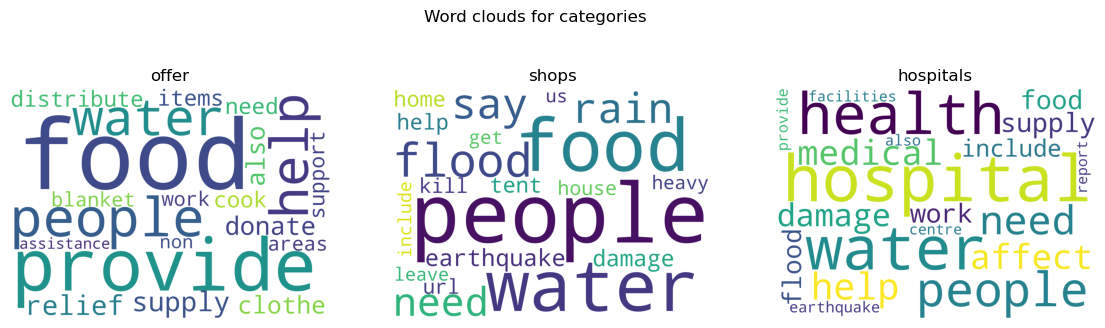

In [17]:
# Print word clouds for up to 3 categories
categories = ['offer', 'shops', 'hospitals']        
cat_word_clouds(categories, df)        

In [18]:
# quick lemmitizer test to take words back to their core
words = ['provide', 'provided', 'providing', 'house', 'houses', 'housing', 'cloths', 'clothes']
lemmatizer = WordNetLemmatizer()
print([lemmatizer.lemmatize(word) for word in words] )
print([lemmatizer.lemmatize(word, wordnet.VERB) for word in words])

['provide', 'provided', 'providing', 'house', 'house', 'housing', 'cloth', 'clothes']
['provide', 'provide', 'provide', 'house', 'house', 'house', 'cloths', 'clothe']



<a class="anchor" id='step3'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">3. Build a machine learning pipeline</span>

This machine pipeline will take in the `message` and `genre` column as input and output classification results on the other 35 categories in the dataset. 

In [19]:
focal_loss = FocalBinaryLoss(gamma = 10)
fl = make_scorer(focal_loss.focal_binary_cross_entropy)

In [20]:
xgb.set_config(verbosity=2)

# cache transformers, so they are only executed once, especially during gridsearch

cachedir = '../cache'

# using defaults of XGBOOST
params = {
    'objective': 'binary:logitraw',
    'n_jobs': -1,
    'max_depth': 8,
    'min_child_weight': 1.4,
    'gamma': 0.6,
    'eval_metric': fl,
    'booster': 'gbtree',   
    'n_estimators': 100,
    'colsample_bytree': 1, # default is 1,
    'subsample': 1, # default is 1
    'tree_method': 'hist', # exact, approx, auto, hist
    'scale_pos_weight': 1,
    'max_delta_step': 15, # default is None
    'reg_lambda': 0.004, # lambda
    'reg_alpha': 0.003, # alpha
    'learning_rate': 0.4,
    'verbosity': 2,
    'random_state' : random_state,
    # one_hot_encoding support is not compatible with column transformer which return an array
    # 'enable_categorical': True,
    # 'max_cat_to_onehot': 5,
    'multi_strategy':'one_output_per_tree',  
}

text_nlp = Pipeline(steps=[
    ('vect', CountVectorizer(tokenizer=tokenize, 
                             token_pattern=None,
                             min_df=3,   # if a word appears in less than 3 documents, ignore it
                             max_df=0.95, # remove too frequent words in 90% of documents
                             max_features=10000, # when using ngram (1,2) make max features higher
                             ngram_range=(1,2))), # ngram (1,2) helps somehow to capture imbalanced classes better    
    ('tfidf', TfidfTransformer(sublinear_tf=False)),    
    ],
    verbose=False)

# preprocessor for NLP
preprocessor = ColumnTransformer(transformers=[
    ('text_vect', text_nlp, 'message'),
    ('one_hot', OneHotEncoder(), ['genre']),    
],
    verbose_feature_names_out=False,
    remainder='drop',
    verbose=False,
)

pipeline_base = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(**params)),    
],
    memory=cachedir,
    verbose=True,
)

<a class="anchor" id='step4'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">4. Set a baseline - Train pipeline and evaluate model</span>

- Split data into train, validation and test datasets, using a custom function that use 'MultilabelStratifiedKFold'
- Oversample the minority classes
- Set a baseline - Train pipeline and evaluate the model
    
**Note**: it is not possible to use multioutput and xgboost with callbacks or early stop for multi label, it is not supported if in a pipeline.

#### Split data into train, validation and test datasets

In [21]:
# features for modelling
X = df[['message', 'genre']].copy(deep=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   message  26179 non-null  object  
 1   genre    26179 non-null  category
dtypes: category(1), object(1)
memory usage: 434.7+ KB


In [22]:
# extract labels
y = df.loc[:, category_names].copy()
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   related                 26179 non-null  int8 
 1   request                 26179 non-null  int8 
 2   offer                   26179 non-null  int8 
 3   aid_related             26179 non-null  int8 
 4   medical_help            26179 non-null  int8 
 5   medical_products        26179 non-null  int8 
 6   search_and_rescue       26179 non-null  int8 
 7   security                26179 non-null  int8 
 8   military                26179 non-null  int8 
 9   water                   26179 non-null  int8 
 10  food                    26179 non-null  int8 
 11  shelter                 26179 non-null  int8 
 12  clothing                26179 non-null  int8 
 13  money                   26179 non-null  int8 
 14  missing_people          26179 non-null  int8 
 15  refugees                

In [23]:
# split data into test, validation, and test datasets, whilst using stratification to handle imbalance
X_train, y_train, X_val, y_val, X_test, y_test = custom_test_val_train_split(X, y, random_state=random_state)

Total records: X(26179, 2):y(26179, 35)
Train shape: X(17452, 2):y(17452, 35)
Validation shape: X(4363, 2):y(4363, 35)
Test shape: X(4364, 2):y(4364, 35)


In [24]:
# make sure data type 'category' is kept
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17452 entries, 2 to 30262
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   message  17452 non-null  object  
 1   genre    17452 non-null  category
dtypes: category(1), object(1)
memory usage: 289.9+ KB


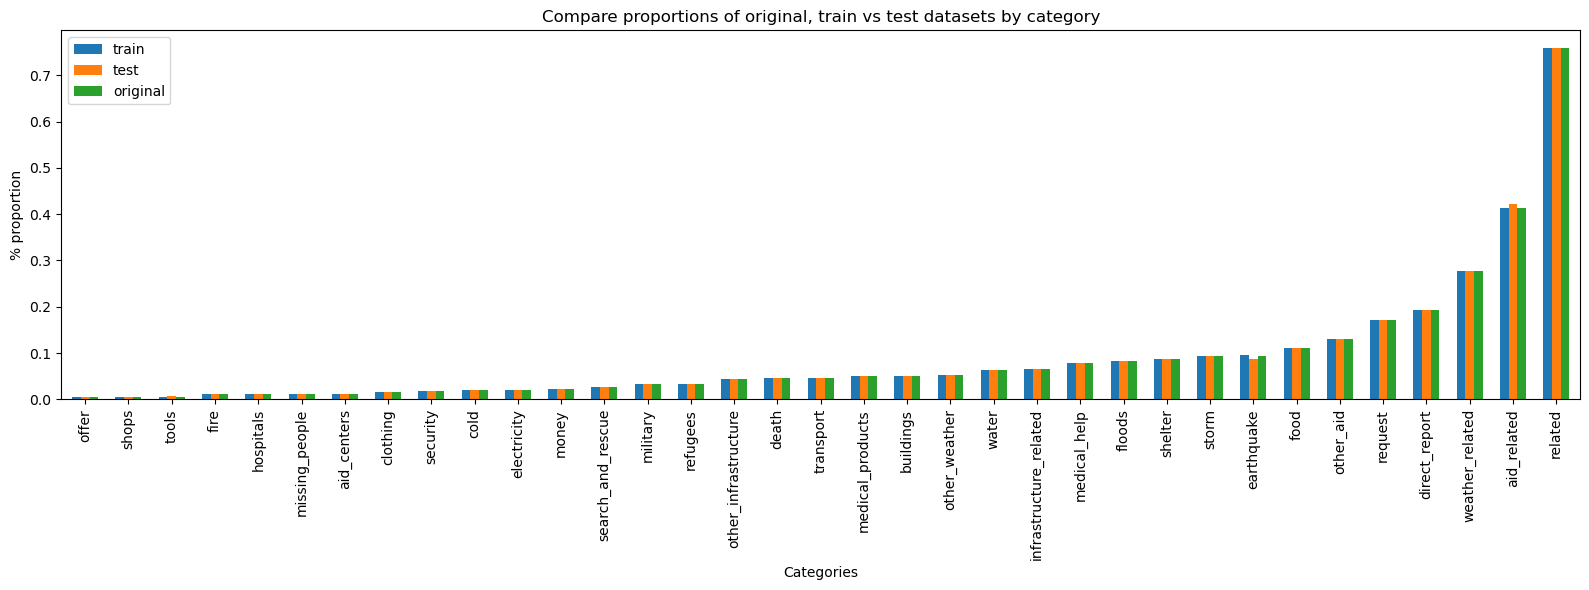

In [25]:
# make sure proportions are the same for original y, test and train datasets due to stratified split
plot_label_proportions(y, y_train, y_test)

>###### Label were split in the same proportions between train, validation and test datasets

#### Oversample the minority classes

A new class was build with two options:
- MLOverSampling.minority_oversampling will duplicate records of minority classes
- MLOverSampling.augment_text will create new records by augmentation to replace some words with synonyms

Data Augmentation will be used for this model

In [26]:
# Oversample the minority classes (simply duplicate lines)
# ml_sampler = MLOverSampling()
# print('Training shapes before: {} {}'.format(X_train.shape, y_train.shape)) 
# X_train_sub, y_train_sub, imbalanced_labels = ml_sampler.minority_oversampling(X_train, y_train)
# print('Training shapes after: {} {}'.format(X_train_sub.shape, y_train_sub.shape))    

# Augment the minority classes (generate new sentences by replacing some words with synonyms)
ml_sampler = MLOverSampling()
print('Training shapes before: {} {}'.format(X_train.shape, y_train.shape)) 
X_train_sub, y_train_sub, imbalanced_labels = ml_sampler.augment_text(X_train, y_train)
print('Training shapes after: {} {}'.format(X_train_sub.shape, y_train_sub.shape)) 

Training shapes before: (17452, 2) (17452, 35)
Imbalanced labels: ['offer', 'security', 'clothing', 'missing_people', 'tools', 'hospitals', 'shops', 'aid_centers', 'fire']
Minority samples: (1395, 2) (1395, 35)
Training shapes after: (30815, 2) (30815, 35)


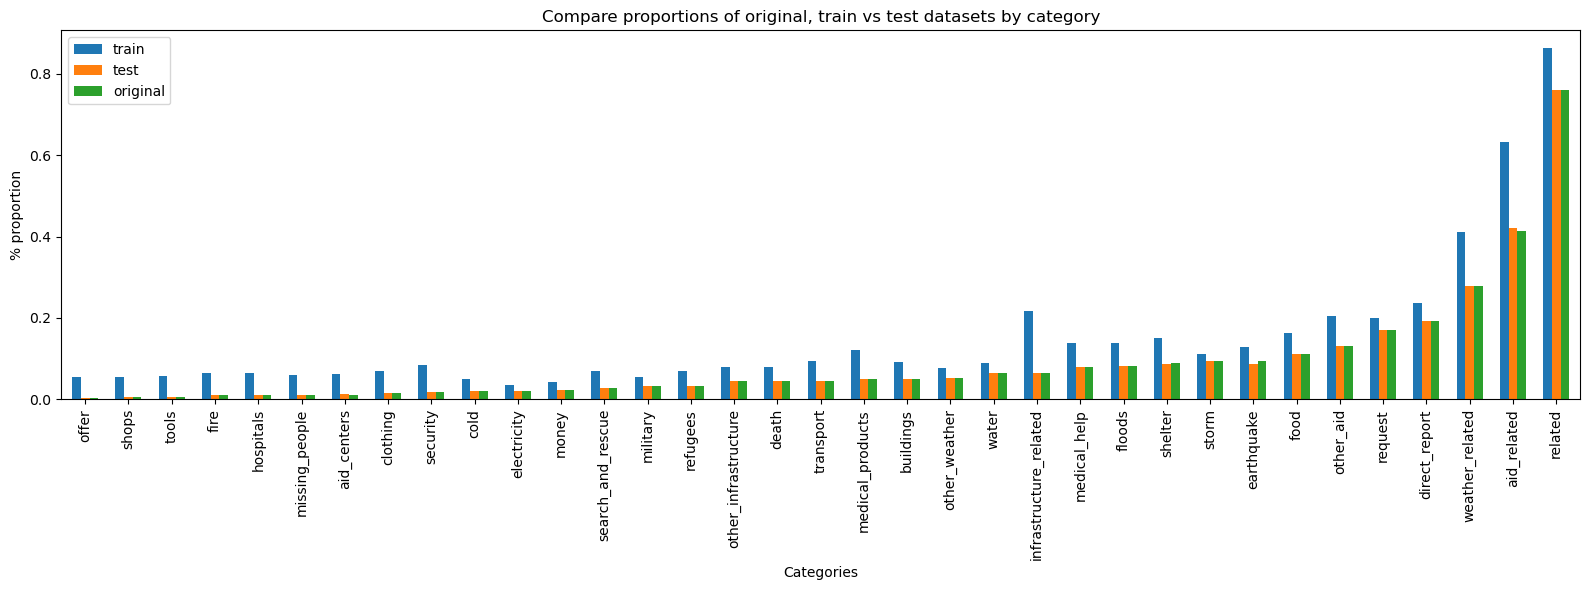

In [27]:
plot_label_proportions(y, y_train_sub, y_test)

> Minority classes on the left now have an increased proportion, whilst test and original y-split have equal proportions of each class

#### Train pipeline

In [28]:
# label_ratio = ml_sampler.get_sample_ratio(y_train_sub)
# sample_weights = calculate_sample_weights(label_ratio, y_train, power=1)
# pipeline_base.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.8min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 6.9min


#### Evaluate the model



In [29]:
# Evaluate results
y_pred_val, score_base = evaluate(X_val, y_val, pipeline_base, zero_division=0)
auc_base = print_results(y_val, y_pred_val)

                        precision    recall  f1-score   support

               related       0.85      0.91      0.88      3313
               request       0.77      0.51      0.62       744
                 offer       0.12      0.05      0.07        20
           aid_related       0.74      0.62      0.68      1801
          medical_help       0.62      0.25      0.36       347
      medical_products       0.59      0.29      0.39       219
     search_and_rescue       0.45      0.12      0.19       121
              security       0.21      0.08      0.11        79
              military       0.60      0.28      0.39       144
                 water       0.75      0.59      0.66       278
                  food       0.79      0.73      0.76       486
               shelter       0.77      0.53      0.63       385
              clothing       0.57      0.49      0.52        68
                 money       0.53      0.25      0.34       100
        missing_people       0.35      

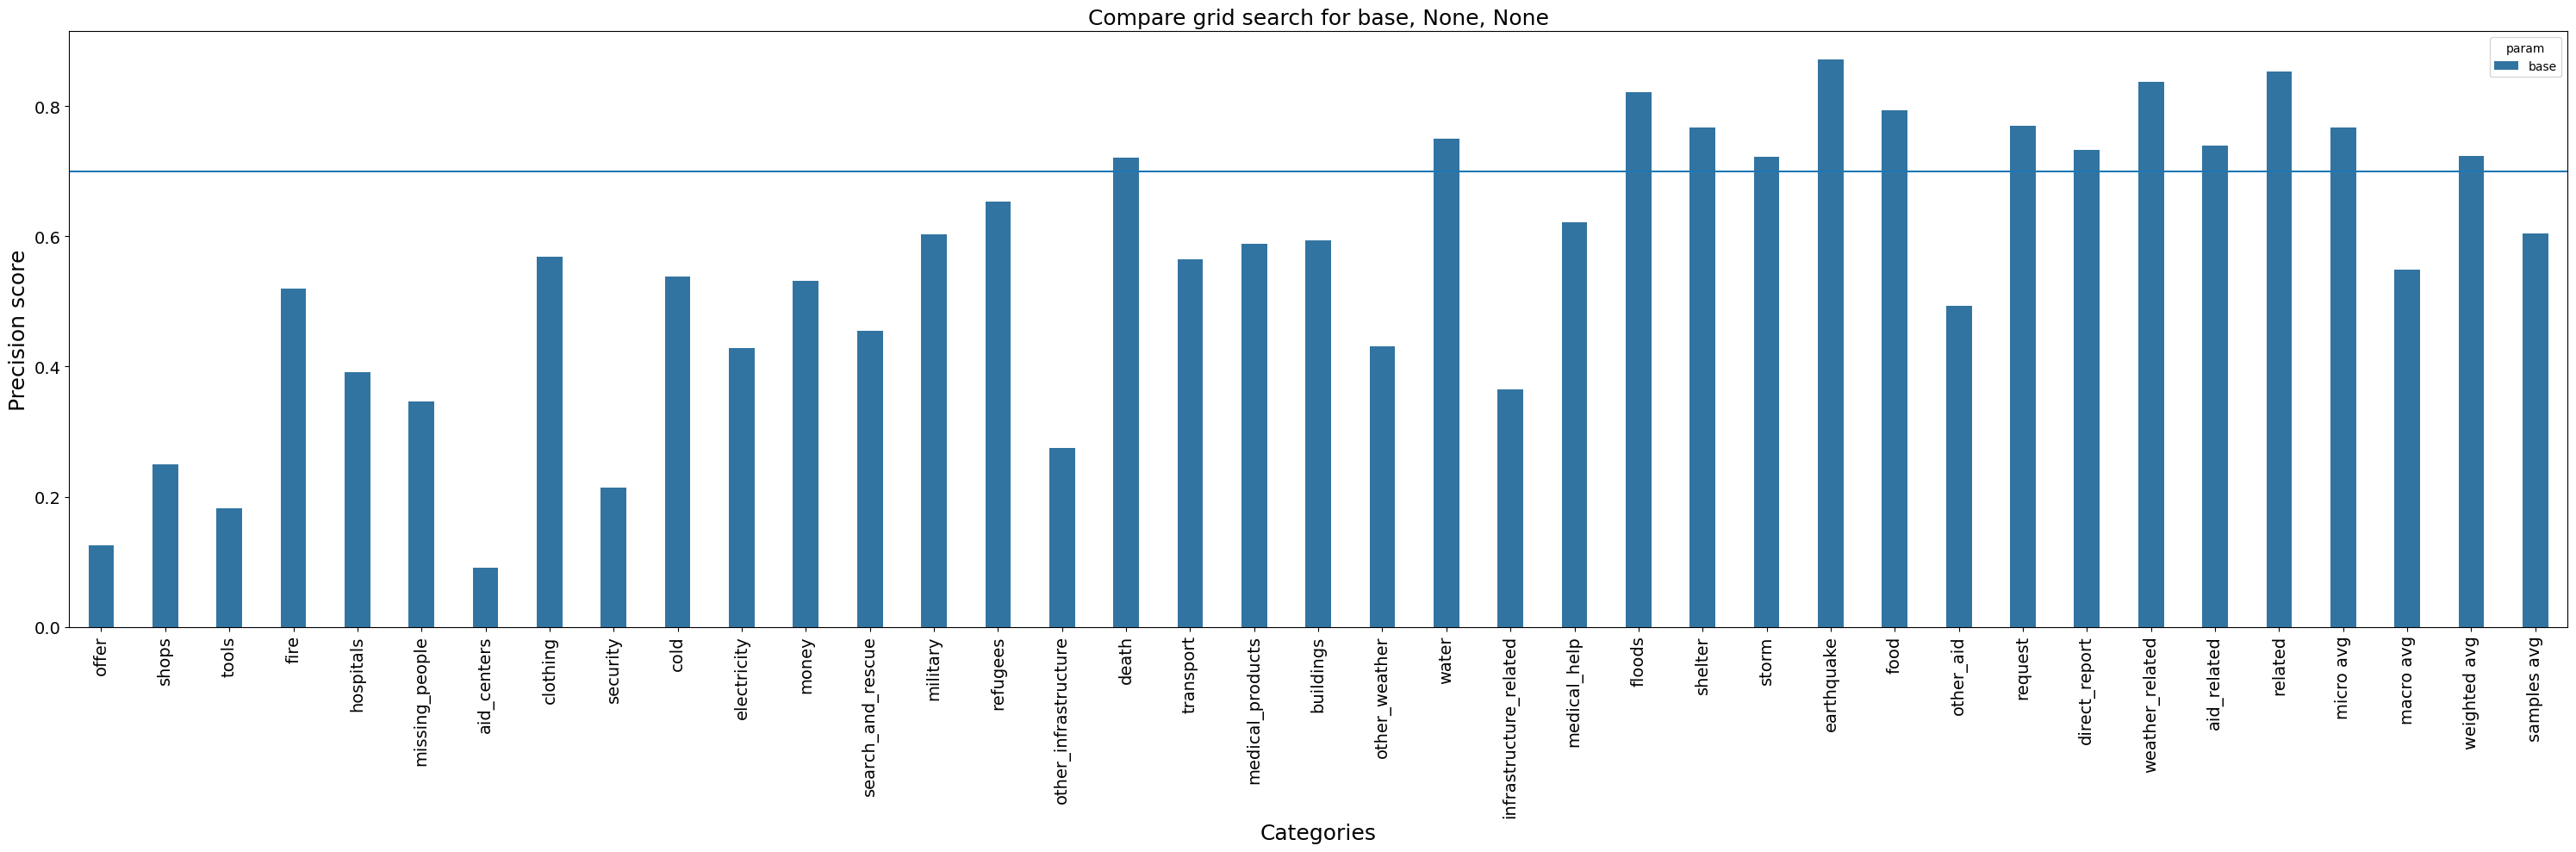

In [30]:
# Update model parameters with cross-validation results
plot_scores(score1=score_base, score2=None, score3=None, score1_name='base', score2_name=None, score3_name=None, order=score_index)

> **Conclusion**: We get reasonable precision covering all labels, even for imbalanced labels. Micro precision at 0.77 and macro precision at 0.55


<a class="anchor" id='step5'></a>
<span style="color:blue; font-size:25px; line-height:40px; font-family: Calibri;">5. Improve the model with GridSearch</span>

Use grid search to find better parameters. 

As **GridSearchCV** usage is a project requirement, demonstrate it's usage by choosing sample ratios to avoid overfitting.

As a second step, [OPTUNA](https://www.dailydoseofds.com/bayesian-optimization-for-hyperparameter-tuning/) will be used for further hyperparameter tuning, as it's much faster.

Both Grid search and Random Search evaluate every hyperparameter configuration independently. Thus, they iteratively explore all hyperparameter configurations to find the most optimal one.

However, Bayesian Optimization takes informed steps based on the results of the previous hyperparameter configurations.

This lets it confidently discard non-optimal configurations. Consequently, the model converges to an optimal set of hyperparameters much faster.

**Precision score** is used as the main metrics, as we don't want to waste resources during a crises. We want to send food and ambulances where we are sure it's needed.

**Macro-average** was selected, to give equal importance by class, to handle class imbalance.
Macro-average will group sample by class and aggregate (using the mean) afterward. Therefore, you increase the importance of data points from under-represented classes because you consider them as important of highly populated classes.

[Click here to see XGBOOST documentation how to handle Imbalance](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#handle-imbalanced-dataset), however this relevant to binary or multi-class problems.

#### 5.1 - Tune `max_depth` and `n_estimators` to control overfitting




In [31]:
verbose = 1
scoring = make_scorer(precision_score, average='macro', zero_division=0)

In [32]:
hyperparameters = {
    "clf__max_depth": [8, 11, 12],
    "clf__n_estimators": [50, 100],
    # "preprocessor__text_vect__vect__max_features": [10000, 12000, 15000]
}

gridsearch1 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=1,
                            random_state=random_state,
                            nr_splits=2)

rmtree(cachedir)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  57.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.9min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  56.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.0min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 3.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 3.2min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.6min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.6min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.1min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.1min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.9min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.8min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.4min
[Pipeline] ......

/opt/anaconda3/envs/disaster_pipeline/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [33]:
# Update model parameters with cross-validation results
pipeline_base.set_params(**gridsearch1.best_params_)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score_gridsearch = evaluate(X_val, y_val, pipeline_base)
auc_gridsearch = print_results(y_val, y_pred_val)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.9min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 6.4min
                        precision    recall  f1-score   support

               related       0.85      0.91      0.88      3313
               request       0.75      0.52      0.62       744
                 offer       0.17      0.05      0.08        20
           aid_related       0.73      0.62      0.67      1801
          medical_help       0.55      0.24      0.34       347
      medical_products       0.57      0.24      0.33       219
     search_and_rescue       0.43      0.12      0.19       121
              security       0.20      0.04      0.06        79
              military       0.63      0.27      0.38       144
                 water       0.76      0.56      0.65       278
                  food       0.79      0.73      0.76       486
               shelter       0.75      0.54      0.63       385
              clothing   

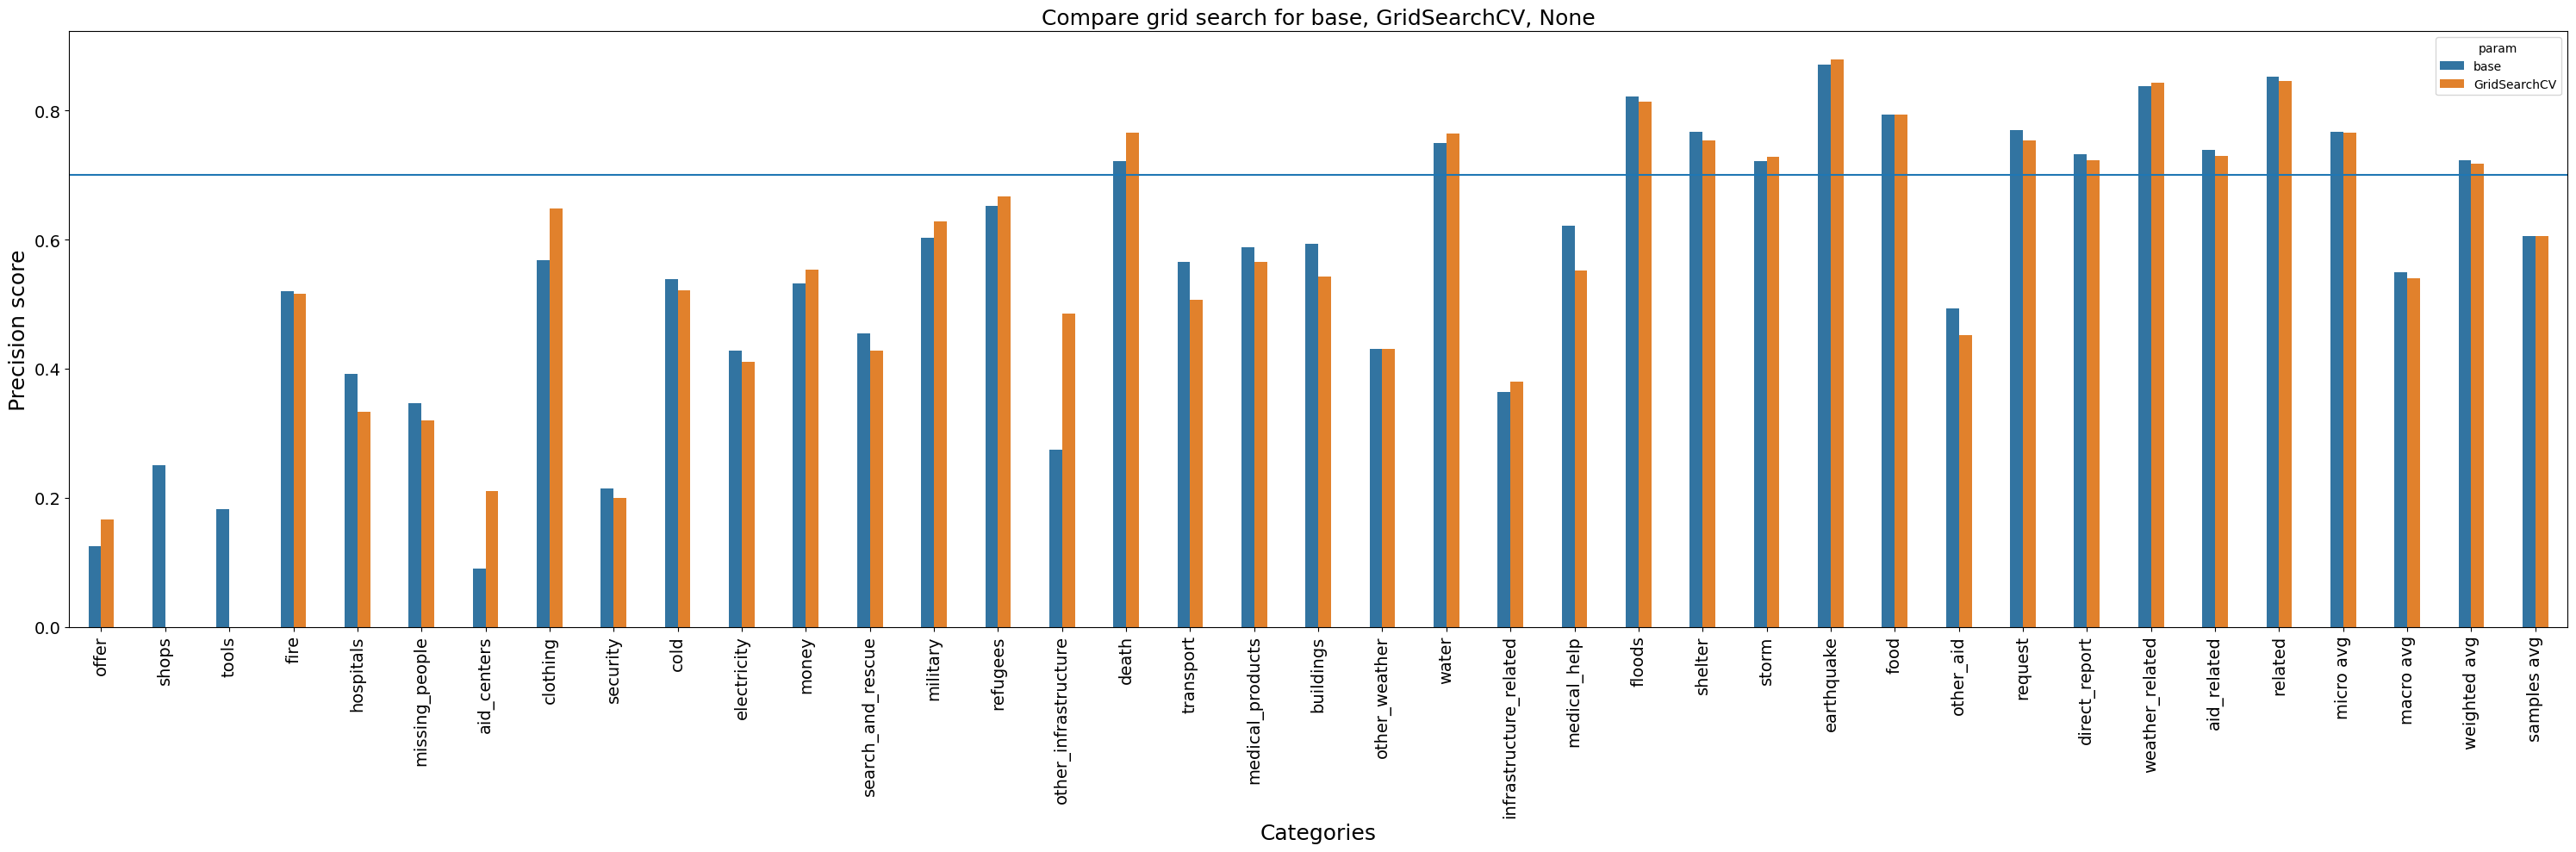

In [34]:
plot_scores(score1=score_base, score2=score_gridsearch, score3=None, score1_name='base', score2_name='GridSearchCV', score3_name=None, order=score_index)

**Conclusion:** Overall most categories have a slight decline in precision agter grid search, with a minority of categories showing a bigger improvement. On average, micro precision stays the same, whilst macro precision decline from 0.56 to 0.54

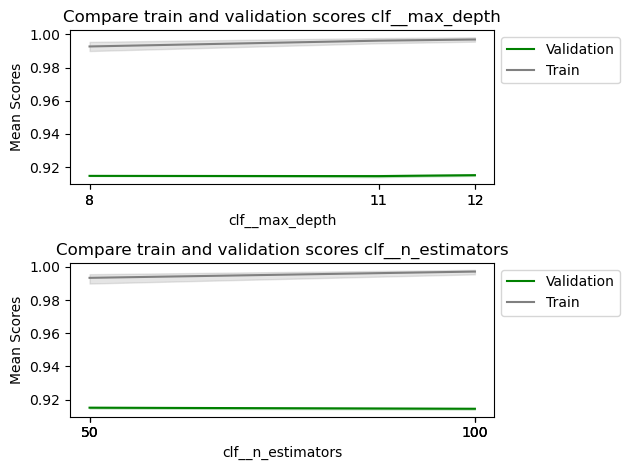

In [35]:
cv_plot_scores(gridsearch1)

In [36]:
print('Base AUC = {}, grid search AUC = {}'.format(auc_base, auc_gridsearch))

Base AUC = 0.6529444406136389, grid search AUC = 0.648068936349712


#### 5.2 - Use OPTUNA for faster grid search for more parameters

In [37]:
# clear the garbage to free memory
gc.collect()

# Unique identifier of the study
# study_name = "xgboost-study-max_df"  
study_name = "xgboost-study1"

# save study to SQLite database
storage_name =config.path_database_optuna

# Propagate logs to the root logger
optuna.logging.enable_propagation()  

# Stop showing logs in sys.stderr
optuna.logging.disable_default_handler()

# Continue grid searching on existing study if it exists (same db and name)
study = optuna.create_study(sampler=TPESampler(), 
                            direction="maximize", 
                            study_name=study_name, 
                            storage=storage_name, 
                            load_if_exists=True )

logger.info("START OPTUNA OPTIMIZATION...")
# study.optimize(objective, n_trials=30)
study.optimize(lambda trial: objective(trial, 
                                       features=X_train_sub, 
                                       labels=y_train_sub, 
                                       model=pipeline_base, 
                                       eval_score=scoring,
                                       n_splits=3,
                                       random_state=random_state), 
               n_trials=3, 
               gc_after_trial=True) 

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

rmtree(cachedir)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.7min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.7min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.2min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.7min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.8min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.8min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.8min
Number of finished trials:  549
Best trial:
  Value: 0.9358661138082169
  Params: 
    clf__max_delta_step: 40.23331277707074
    clf__max_depth: 11

In [38]:
print(f"---Bayesian Optimization---")
print(f"Number of iterations: {len(study.trials)}")
print(f"Best trial index: {study.best_trial.number}")
print(f"Best score: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_params}")

---Bayesian Optimization---
Number of iterations: 549
Best trial index: 159
Best score: 0.9358661138082169
Best hyperparameters: {'clf__max_delta_step': 40.23331277707074, 'clf__max_depth': 11, 'clf__reg_lambda': 0.019710998210811237, 'clf__gamma': 25.047678170913976, 'clf__min_child_weight': 2.2956319404678, 'clf__reg_alpha': 1.834436046249881, 'clf__learning_rate': 0.0372265279270068, 'clf__grow_policy': 'lossguide'}


In [39]:
# load study results into a dataframe
optuna_study = study.trials_dataframe()
optuna_study.head()

,number,value,datetime_start,datetime_complete,duration,params_clf__gamma,params_clf__grow_policy,params_clf__learning_rate,params_clf__max_delta_step,params_clf__max_depth,params_clf__min_child_weight,params_clf__reg_alpha,params_clf__reg_lambda,state
0,0,0.641197059210350195357364100345876067876815795898437500,2024-09-16 23:40:44.947875,2024-09-16 23:45:34.000186,0 days 00:04:49.052311,34.224597843421527443297236459329724311828613281250,depthwise,0.5926803180751558652872290622326545417308807373046875000000,14.592736422565732112843761569820344448089599609375,2,38.9910195103666197269376425538212060928344726562500,5.12699130717992002104210769175551831722259521484375,16.710770919616891205805586650967597961425781250000,COMPLETE
1,1,0.227012175572470498163824004222988151013851165771484375,2024-09-16 23:45:34.026193,2024-09-16 23:48:40.758092,0 days 00:03:06.731899,42.335211544290991980687977047637104988098144531250,lossguide,9.9488067753424314076937662321142852306365966796875000000000,76.261847882425982447784917894750833511352539062500,10,6.9214245682611927890093284077011048793792724609375,16.32976311895370358229229168500751256942749023437500,16.626244855571506775504531105980277061462402343750,COMPLETE
2,2,0.494928872778903572449138437150395475327968597412109375,2024-09-16 23:48:40.779950,2024-09-16 23:51:30.704368,0 days 00:02:49.924418,34.320609658988402657087135594338178634643554687500,lossguide,8.2697323708909937778344101388938724994659423828125000000000,17.510360352427024821508894092403352260589599609375,2,23.1104070741239659980692522367462515830993652343750,4.77330291297864128807759698247537016868591308593750,2.052228921455938603912727558054029941558837890625,COMPLETE
3,3,0.561721760927122337747618985304143279790878295898437500,2024-09-16 23:51:30.725345,2024-09-16 23:54:30.759928,0 days 00:03:00.034583,19.975407984335991073976401821710169315338134765625,lossguide,0.1818427813132979797838828517342335544526576995849609375000,93.209706420290444839338306337594985961914062500000,2,36.0532046716371681327473197598010301589965820312500,29.66420264004590379158798896241933107376098632812500,20.157874906410246040877609630115330219268798828125,COMPLETE
4,4,0.722460820332273656596555611031362786889076232910156250,2024-09-16 23:54:30.780774,2024-09-16 23:59:12.814192,0 days 00:04:42.033418,27.698100572601802582539676222950220108032226562500,depthwise,0.0284651500484887666486688573286301107145845890045166015625,58.511931035252970900728541892021894454956054687500,9,20.4426905217078456189483404159545898437500000000000,6.57990980187102714182856288971379399299621582031250,13.046771342297304840940341819077730178833007812500,COMPLETE


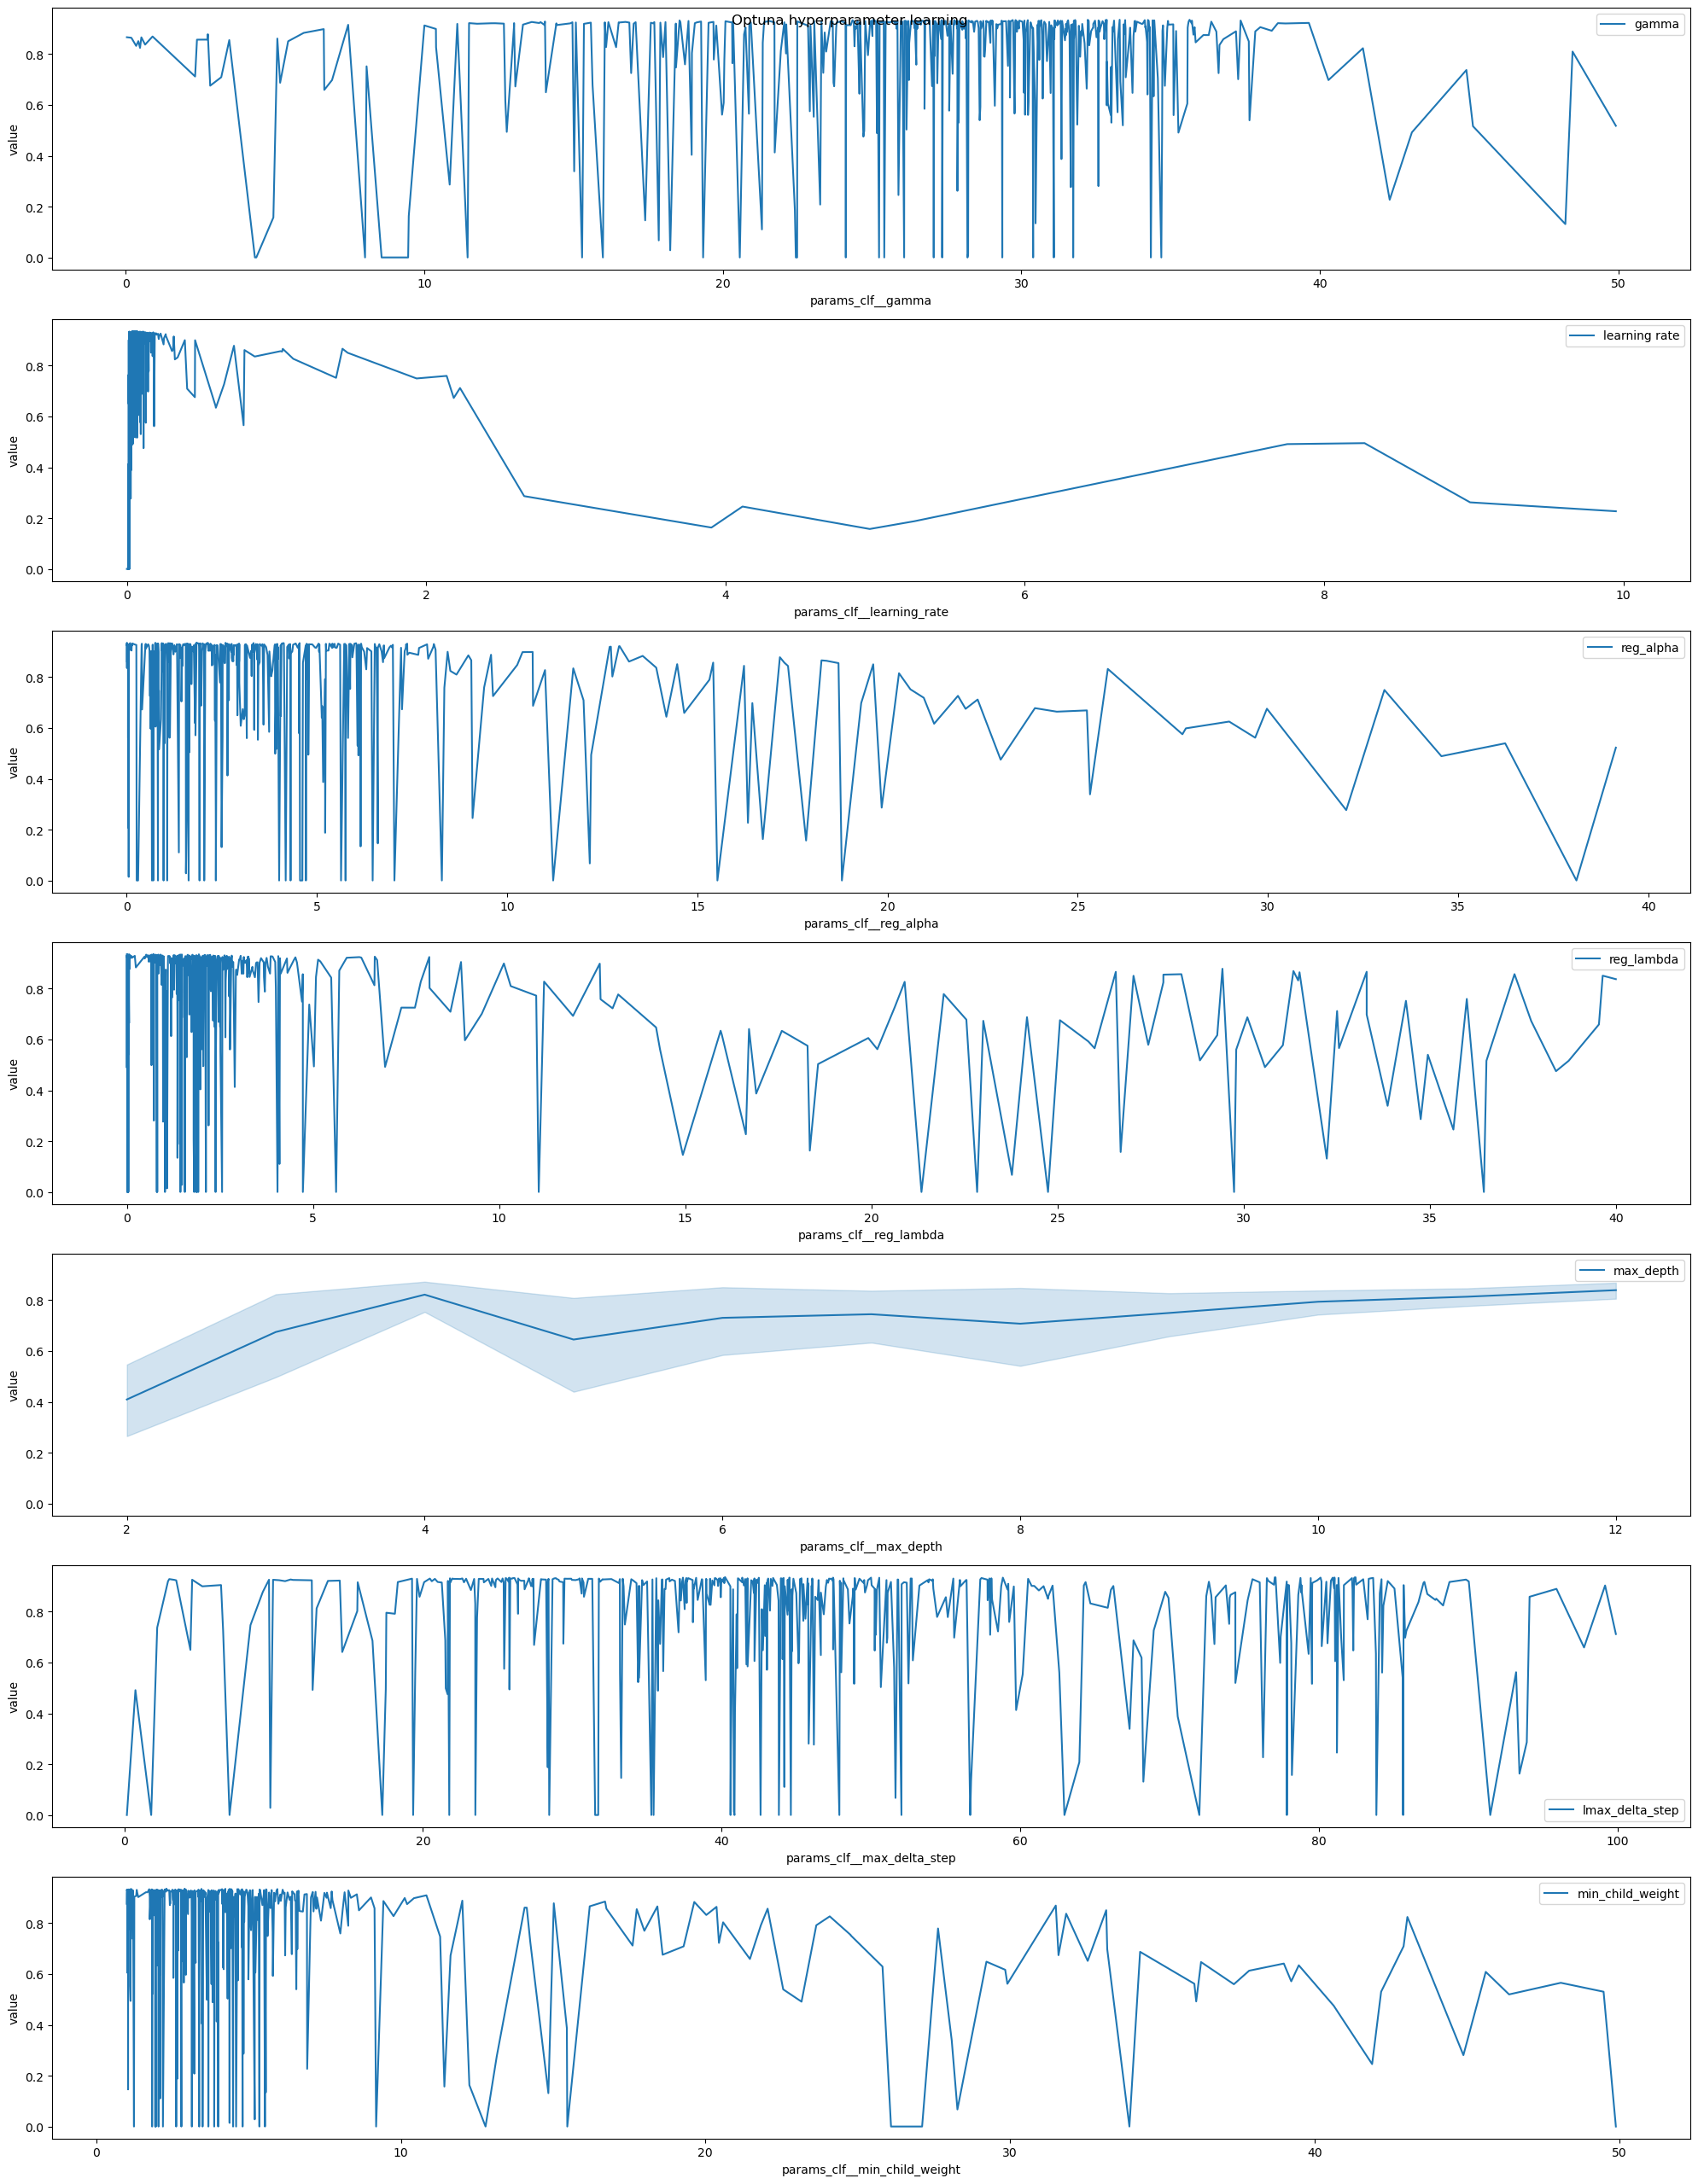

In [40]:
# plot performance of learning rate and gamma
fig, ax = plt.subplots(7, sharey=True, figsize=(20,26))
sns.lineplot(data=optuna_study, x='params_clf__gamma', y='value', label='gamma', ax=ax[0])
sns.lineplot(data=optuna_study, x='params_clf__learning_rate', y='value', label='learning rate', ax=ax[1])
sns.lineplot(data=optuna_study, x='params_clf__reg_alpha', y='value', label='reg_alpha', ax=ax[2])
sns.lineplot(data=optuna_study, x='params_clf__reg_lambda', y='value', label='reg_lambda', ax=ax[3])
sns.lineplot(data=optuna_study, x='params_clf__max_depth', y='value', label='max_depth', ax=ax[4])
sns.lineplot(data=optuna_study, x='params_clf__max_delta_step', y='value', label='lmax_delta_step', ax=ax[5])
sns.lineplot(data=optuna_study, x='params_clf__min_child_weight', y='value', label='min_child_weight', ax=ax[6])
plt.suptitle('Optuna hyperparameter learning')
plt.tight_layout()

In [42]:
pipeline_base.set_params(**study.best_params)

# make sure parameters are set correctly
pipeline_base.get_params()

{'memory': '../cache',
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('text_vect',
                                    Pipeline(steps=[('vect',
                                                     CountVectorizer(max_df=0.95,
                                                                     max_features=10000,
                                                                     min_df=3,
                                                                     ngram_range=(1,
                                                                                  2),
                                                                     token_pattern=None,
                                                                     tokenizer=<function tokenize at 0x7ff60d62df70>)),
                                                    ('tfidf',
                                                     TfidfTransformer())]),
                                    'message'),
                       

In [43]:
# clear the garbage to free memory
gc.collect()

pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score_optuna = evaluate(X_val, y_val, pipeline_base)
auc_optuna = print_results(y_val, y_pred_val)
rmtree(cachedir)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.9min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 5.3min
                        precision    recall  f1-score   support

               related       0.85      0.88      0.86      3313
               request       0.82      0.38      0.52       744
                 offer       0.00      0.00      0.00        20
           aid_related       0.76      0.46      0.57      1801
          medical_help       0.89      0.05      0.09       347
      medical_products       0.59      0.19      0.29       219
     search_and_rescue       0.67      0.05      0.09       121
              security       0.00      0.00      0.00        79
              military       0.78      0.05      0.09       144
                 water       0.82      0.49      0.61       278
                  food       0.76      0.70      0.73       486
               shelter       0.81      0.49      0.61       385
              clothing   

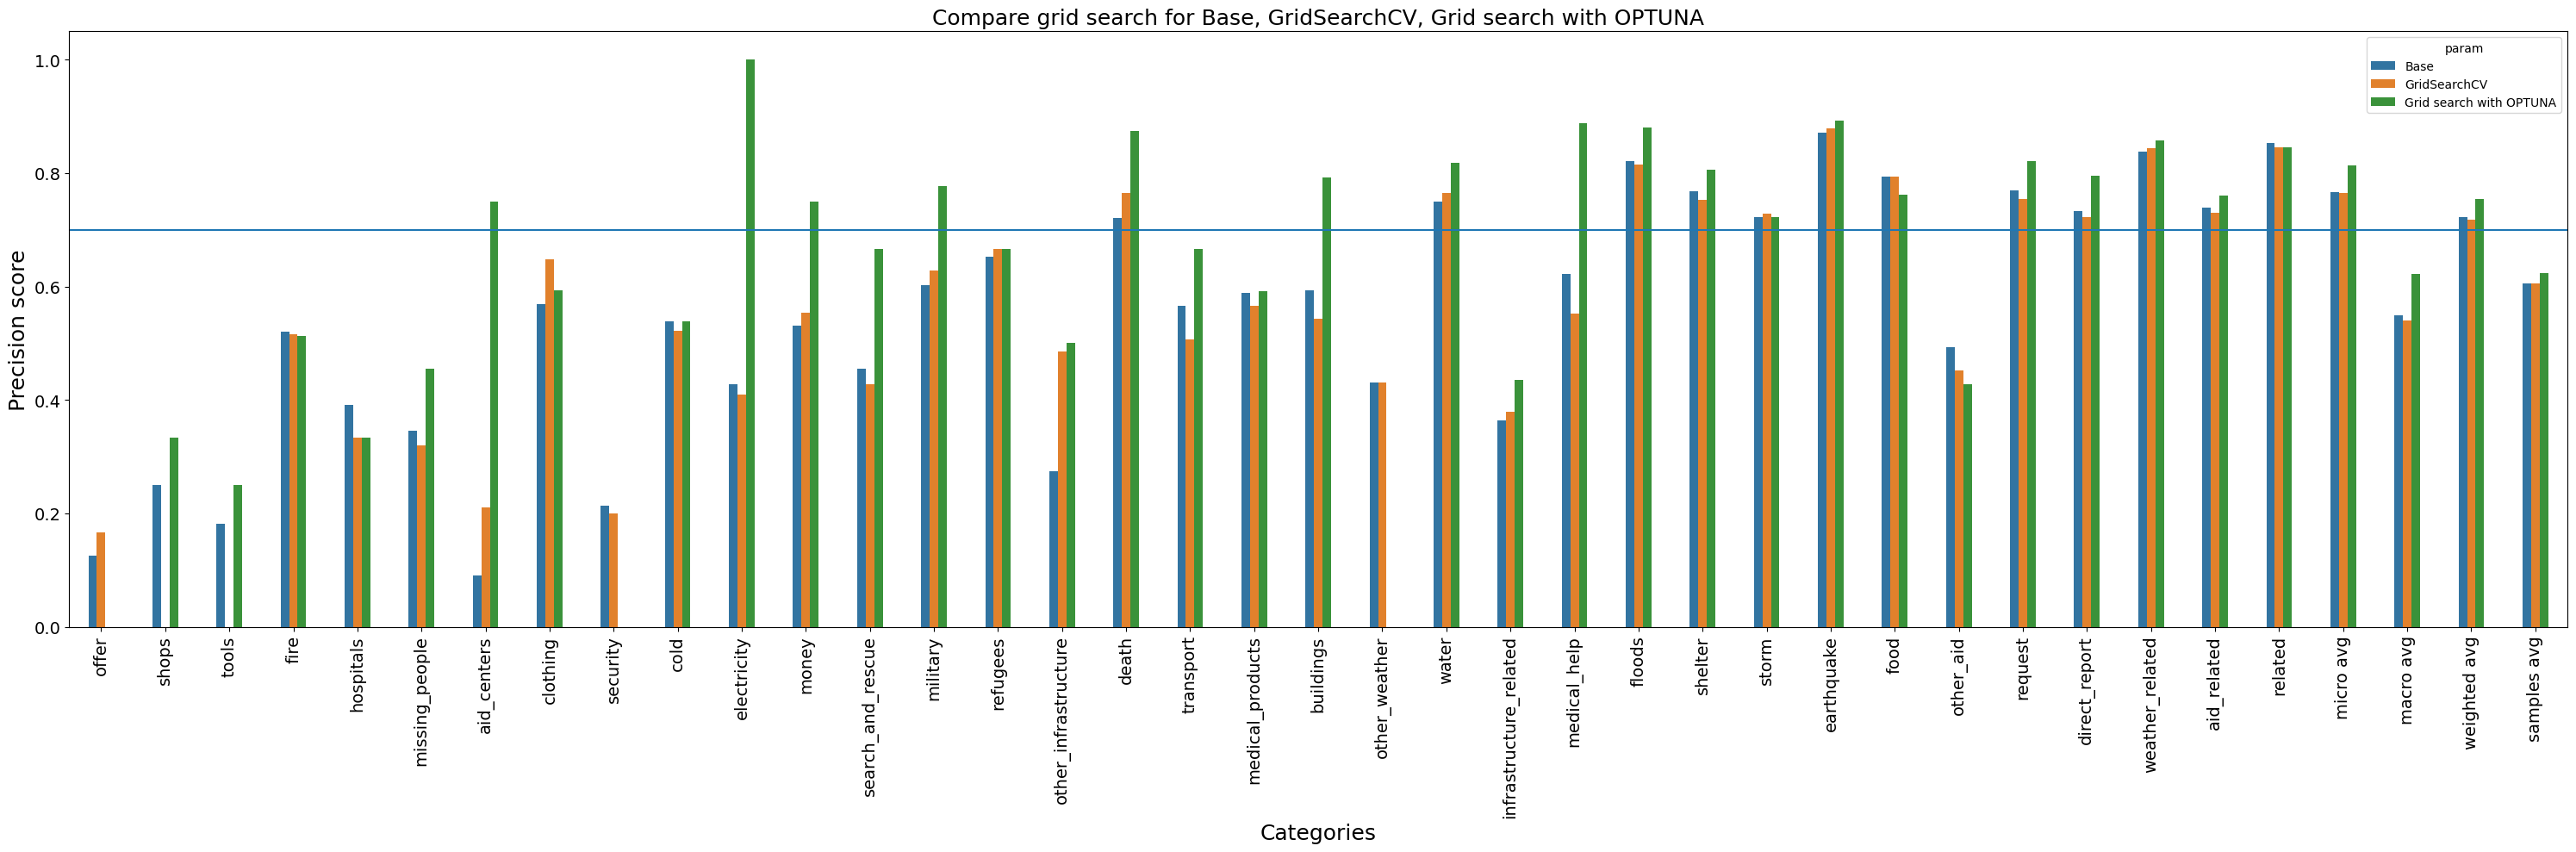

In [44]:
# Update model parameters with cross-validation results
plot_scores(score1=score_base, score2=score_gridsearch, score3=score_optuna, score1_name='Base', score2_name='GridSearchCV', score3_name='Grid search with OPTUNA', order=score_index)

>**Conclusion:** After grid search with Optuna, **micro precision** improves from 0.77 to 0.81, and macro precision improves from 0.56 to 62 compared with the BASE. That's amazing ! Most categories shows coverage even imbalanced labels.

<a class="anchor" id='step6'></a>
<span style="color:blue; font-size:25px; line-height:40px; font-family: Calibri;">6. Try improving your model further</span>

* Add `starting_verb` feature
* Try to use embeddings from OpenAI to see if context is better understood

<a class="anchor" id='step62'></a>
<span style="color:blue; font-size:20px; line-height:40px; font-family: Calibri;">6.1 Add new feature 'starting_verb'</span>

In [45]:
# clear the garbage and cache to free memory
gc.collect()

# cache transformers, so they are only executed once, especially during gridsearch
cachedir = '../cache'

# update parameters with grid search results
params_new = pipeline_base['clf'].get_params()

# preprocessor for NLP
text_nlp = Pipeline(steps=[
    ('vect', CountVectorizer(tokenizer=tokenize, 
                             token_pattern=None,
                             min_df=3,   # if a word appears in less than 3 documents, ignore it
                             max_df=0.95, # remove too frequent words  
                             max_features=10000,
                             ngram_range=(1,2))),    
    ('tfidf', TfidfTransformer(sublinear_tf=False)),    
    ],
    verbose=False)

preprocessor = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(), ['genre']), 
    ('starting_verb', StartingVerbExtractor(), ['message']),    
    ('text_vect', text_nlp, 'message'),
    
],
    verbose_feature_names_out=False,
    remainder='drop',
    verbose=False,
)

pipeline_starting_verb = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(**params_new)),    
],
    memory=cachedir,
    verbose=True,
)

In [46]:
# train classifier
pipeline_starting_verb.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.6min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 5.3min


In [47]:
y_pred_val, score_verb = evaluate(X_val, y_val, pipeline_starting_verb)
auc_verb = print_results(y_val, y_pred_val)

                        precision    recall  f1-score   support

               related       0.85      0.88      0.86      3313
               request       0.82      0.38      0.52       744
                 offer       0.00      0.00      0.00        20
           aid_related       0.76      0.46      0.57      1801
          medical_help       0.89      0.05      0.09       347
      medical_products       0.59      0.19      0.29       219
     search_and_rescue       0.67      0.05      0.09       121
              security       0.00      0.00      0.00        79
              military       0.78      0.05      0.09       144
                 water       0.82      0.49      0.61       278
                  food       0.76      0.70      0.73       486
               shelter       0.81      0.49      0.61       385
              clothing       0.59      0.51      0.55        68
                 money       0.75      0.03      0.06       100
        missing_people       0.45      

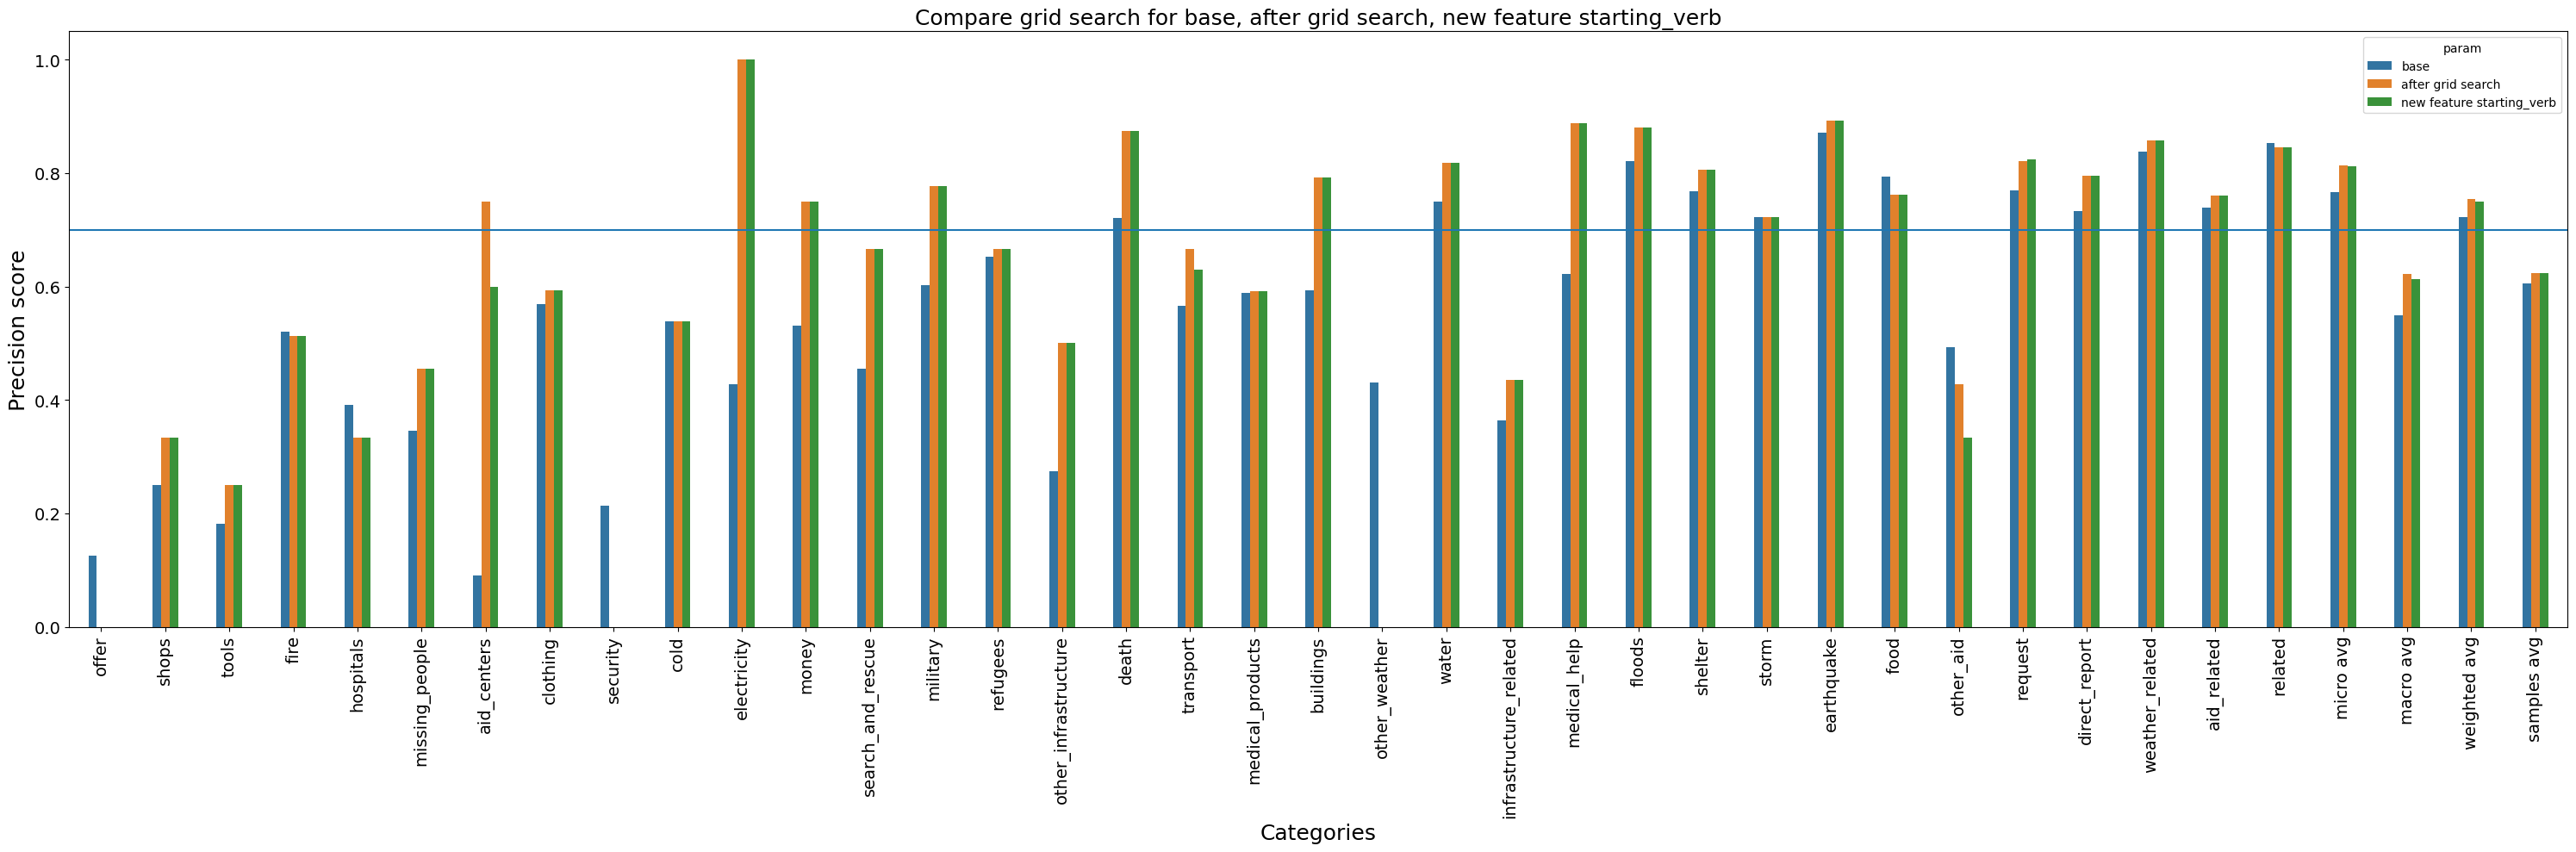

In [48]:
plot_scores(score1=score_base, score2=score_optuna, score3=score_verb, score1_name='base', score2_name='after grid search', score3_name='new feature starting_verb', order=score_index)

>Conclusion: Adding a new feature `starting_verb` brings very little improvement. Macro precision shows a slight decline.

In [49]:
print('Base AUC = {}\nAfter cross validation AUC = {}\nAdding verb AUC = {}\n'.format(auc_base, auc_optuna, auc_verb))

Base AUC = 0.6529444406136389
After cross validation AUC = 0.6119852874480741
Adding verb AUC = 0.612475030247704



##### A new grid search for new feature 'starting_verb`

In [50]:
# optuna.delete_study(study_name="xgboost-study-openai", storage=config.path_database_optuna)

In [51]:
# clear the garbage to free memory
gc.collect()

# Unique identifier of the study
study_name = "xgboost-study-starting_verb"  

# save study to SQLite database
storage_name =config.path_database_optuna

# Propagate logs to the root logger
optuna.logging.enable_propagation()  

# Stop showing logs in sys.stderr
optuna.logging.disable_default_handler()

# Continue grid searching on existing study if it exists (same db and name)
study_starting_verb = optuna.create_study(sampler=TPESampler(), 
                                          direction="maximize", 
                                          study_name=study_name, 
                                          storage=storage_name, 
                                          load_if_exists=True)

logger.info("START OPTUNA OPTIMIZATION FOR STARTING_VERB...")
# study_starting_verb.optimize(objective_starting_verb, n_trials=60)
study_starting_verb.optimize(lambda trial: objective(trial, 
                                                     features=X_train_sub, 
                                                     labels=y_train_sub, 
                                                     model=pipeline_starting_verb, 
                                                     eval_score=scoring, 
                                                     n_splits=3,
                                                     random_state=random_state), 
                             n_trials=3, 
                             gc_after_trial=True) 

print("Number of finished trials: ", len(study_starting_verb.trials))
print("Best trial:")
trial_verb = study_starting_verb.best_trial

print("  Value: {}".format(trial_verb.value))
print("  Params: ")
for key, value in trial_verb.params.items():
    print("    {}: {}".format(key, value))

rmtree(cachedir)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.8min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.8min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.7min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.7min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.7min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.7min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.2min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.2min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.3min
Number of finished trials:  106
Best trial:
  Value: 0.9231038755305045
  Params: 
    clf__max_delta_step: 8.589038139451809
    clf__max_depth: 12

In [52]:
# refit the model with best hyperparameters
pipeline_starting_verb.set_params(**study_starting_verb.best_params)

# make sure parameters are set correctly
pipeline_starting_verb['clf'].get_params()

{'objective': 'binary:logitraw',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': make_scorer(focal_binary_cross_entropy, response_method='predict'),
 'feature_types': None,
 'gamma': 14.582944434925844,
 'grow_policy': 'lossguide',
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.07449881815731174,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': 8.589038139451809,
 'max_depth': 12,
 'max_leaves': None,
 'min_child_weight': 2.2621274900536674,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': 'one_output_per_tree',
 'n_estimators': 50,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 10,
 'reg_alpha': 3.5242494358597716,
 'reg_lambda': 5.9438295307492615,
 'sampling_method': None,
 'scale_pos_weight

In [53]:
# refit the model with best hyperparameters
pipeline_starting_verb.fit(X_train_sub, y_train_sub)
y_pred_val, score_verb = evaluate(X_val, y_val, pipeline_starting_verb)
auc_verb = print_results(y_val, y_pred_val)
rmtree(cachedir)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.6min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 5.4min
                        precision    recall  f1-score   support

               related       0.81      0.95      0.88      3313
               request       0.79      0.48      0.60       744
                 offer       0.00      0.00      0.00        20
           aid_related       0.72      0.60      0.66      1801
          medical_help       0.72      0.14      0.23       347
      medical_products       0.58      0.20      0.29       219
     search_and_rescue       0.67      0.12      0.20       121
              security       0.33      0.01      0.02        79
              military       0.82      0.12      0.22       144
                 water       0.77      0.57      0.65       278
                  food       0.76      0.71      0.73       486
               shelter       0.82      0.51      0.62       385
              clothing   

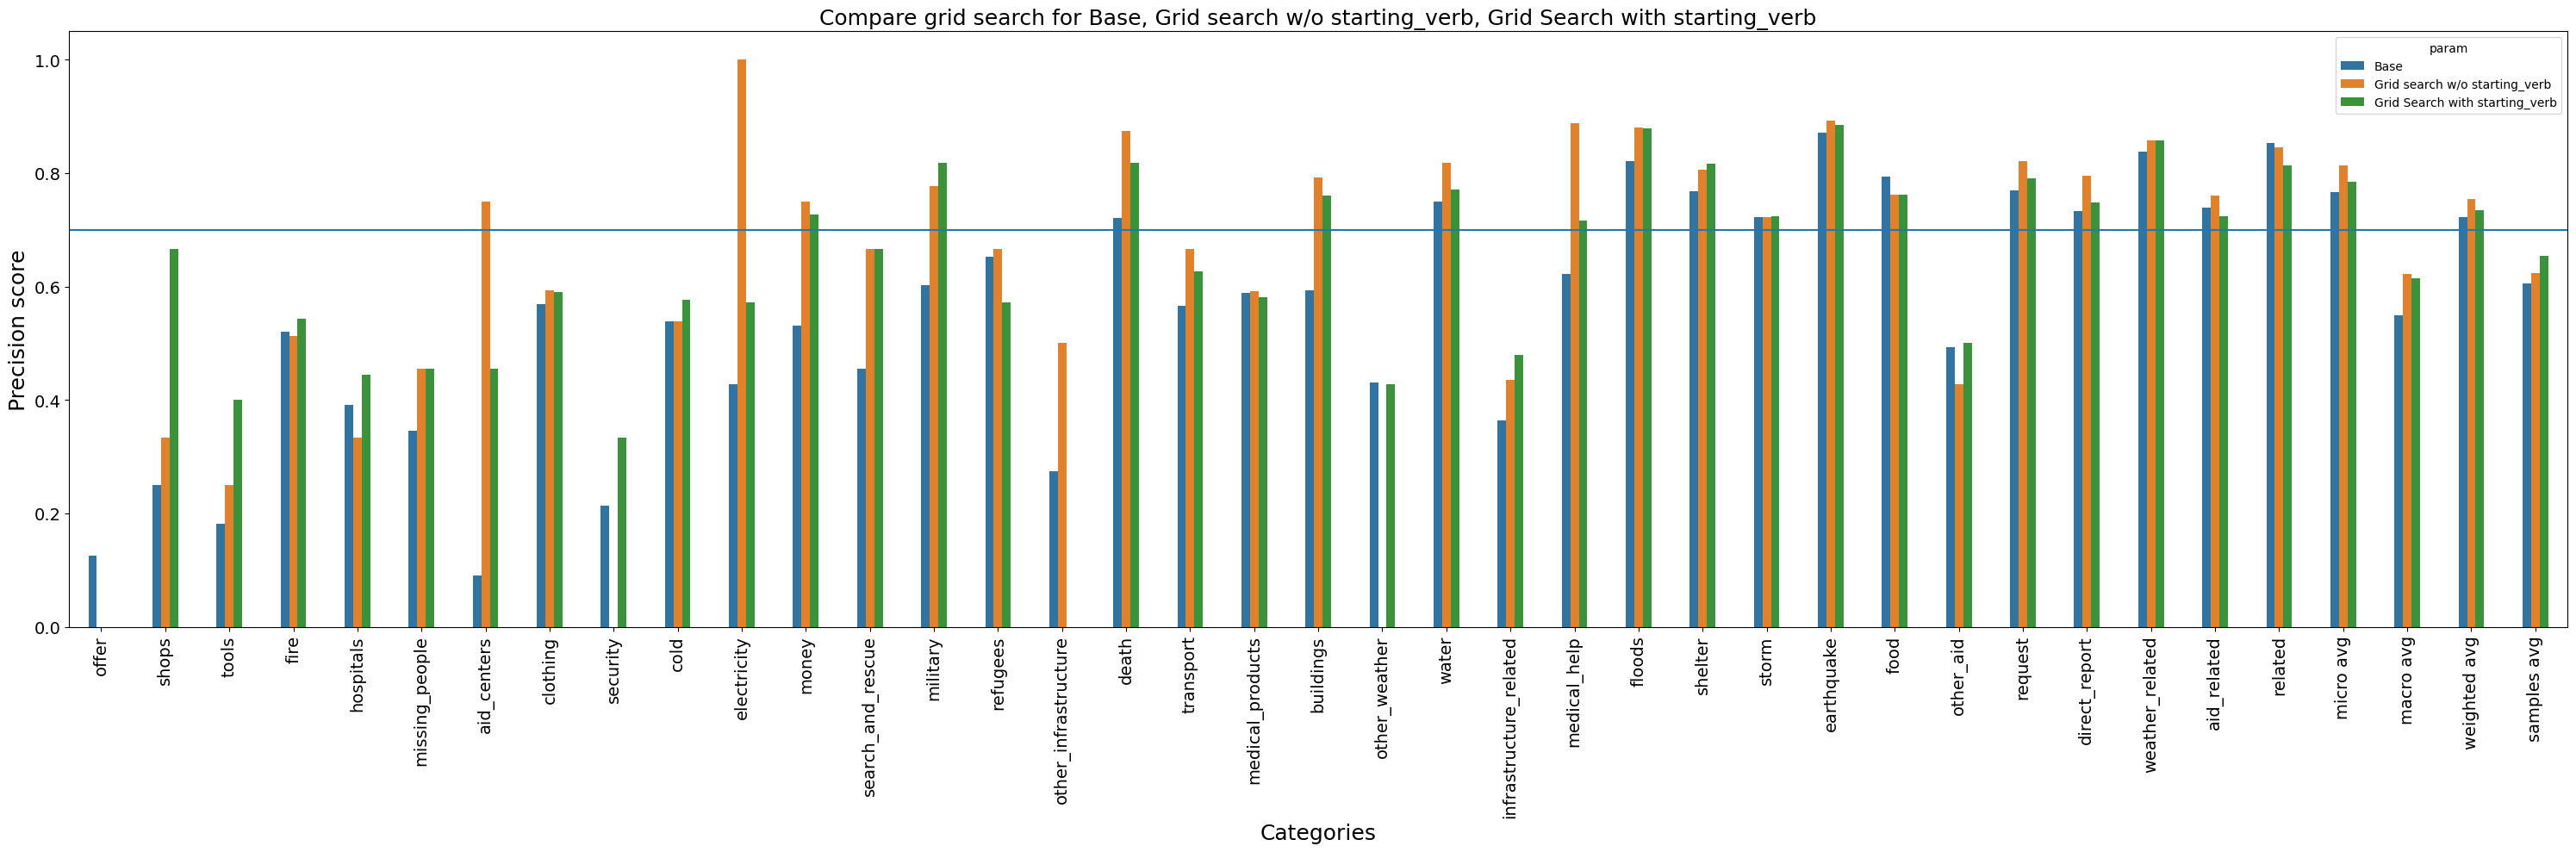

In [54]:
# Update model parameters with cross-validation results
plot_scores(score1=score_base, score2=score_optuna, score3=score_verb, score1_name='Base', score2_name='Grid search w/o starting_verb', score3_name='Grid Search with starting_verb', order=score_index)

**Conclusion**: Even after a new grid search, the model with `starting_verb` shows a slight decline in performance.

<a class="anchor" id='step63'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">6.2 JUST FOR FUN: Use OpenAI to create embeddings instead of tokenizer</span>

Verify inputs don't exceed the maximum length

The maximum length of input text for our latest embedding models is 8192 tokens. You should verify that your inputs don't exceed this limit before making a request.
If sending an array of inputs in a single embedding request the max array size is 2048.

In [55]:
# clear the garbage to free memory
gc.collect()

1460

In [56]:
df_embeddings = df.copy(deep=True)
df_embeddings.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
# Setting the API key to use OPEN AI models
openai_api_key = os.environ.get('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key, max_retries=5)

# default openai settings
embedding_model = "text-embedding-3-large"
# embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [58]:
def get_embeddings(
    list_of_text: List[str], model="text-embedding-3-small", **kwargs
) -> List[List[float]]:
    """ Use OpenAI to generate embeddings """
    
    assert len(list_of_text) <= 2048, "The batch size should not be larger than 2048."
   
    # clean up the text just a little bit 
    list_of_text =[tokenizer_light(text) for text in list_of_text]    

    # text_embedding_3_large model always brings back only 3072 dimensions
    data = client.embeddings.create(input=list_of_text,
                                    model=model, 
                                    encoding_format="float",
                                    # dimensions=1000,
                                    **kwargs).data
    
    return [d.embedding for d in data]

In [59]:
# how many tokens do we have?  
encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df_embeddings["n_tokens"] = df_embeddings.message.apply(lambda x: len(encoding.encode(x)))

print('Total tokens is {}'.format(df_embeddings["n_tokens"].sum()))
print('Longest token is {}'.format(df_embeddings["n_tokens"].max()))

Total tokens is 829535
Longest token is 2209


In [60]:
# for how many records is token value 0 or too small?
print('Number of records with too small tokens is {}'.format(
    len(df_embeddings[df_embeddings['n_tokens'] < 2])))

# get index of those records with too small tokens
idx = df_embeddings[df_embeddings['n_tokens'] < 2].index

# drop those records with too small tokens as they cause errors
df_embeddings = df_embeddings.drop(idx, axis=0)

Number of records with too small tokens is 3


In [61]:
# Only 50,000 tokens can be processed at a time. As we have over 800k tokens, we need to process them in batch

records = df_embeddings[['message']].to_dict("records")
print("Records to process: ", len(records))
product_vectors = []
docs = []
batchsize = 2000

for idx,doc in enumerate(records,start=1):
    # create byte vectors
    docs.append(doc["message"])
    if idx % batchsize == 0:
        product_vectors += get_embeddings(docs, embedding_model)
        docs.clear()
        print("Vectors processed ", len(product_vectors), end='\r')

product_vectors += get_embeddings(docs, embedding_model)
print("\nVectors processed ", len(product_vectors))

Records to process:  26176


In [62]:
# add embedding back to dataframe and save
df_embeddings['embedding'] = product_vectors
df_embeddings.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,n_tokens,embedding
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,"[-0.02305123, -0.013979053, -0.0040855985, 0.023231426, 0.018477023, -0.020445319, 0.0046192557, -0.0042865863, -0.03348874, 0.048320256, 0.0106731495, 0.0030893222, 0.0009971424, 0.02619773, -0.01281471, 0.014720629, -0.038534228, 0.0074226903, 0.031964004, 0.00027224328, -0.012592929, -0.0010751119, -0.019156223, 0.021193825, 0.03113233, 0.0036455041, 0.006140526, 0.015871111, 0.028055135, 0..."
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,9,"[-0.017563928, -0.006729741, -0.008913616, 0.019345101, -0.04318186, -0.006857521, -0.021451533, -0.015380053, -0.009811947, 0.0095641315, 0.024797043, -0.005084091, -0.0142726265, 0.007810062, -0.026702126, -0.0017501974, -0.04157106, 0.0013436249, 0.010361788, -0.0012584383, 8.663864e-05, 0.01936059, -0.0756457, 0.043336745, -0.0066445544, 0.010307578, -0.014264883, 0.016340338, 0.013513692,..."
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,"[-0.013288714, 0.019643435, -0.012510586, -0.01034047, -0.012294439, 0.03811103, -0.012804545, -0.0008645878, -0.015796019, 0.00884041, 0.0011250449, 0.009294319, -0.010660367, 0.020058436, 0.02069823, 0.029292235, -0.030070363, 0.0130034005, -0.01107537, -0.028600564, -0.016591439, -0.04295272, 0.00884041, 0.007599727, 0.039840207, -0.0015184323, -0.005524716, -0.007305767, -0.008183324, 0.01..."
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,23,"[0.021157239, 0.009059386, -0.00633947, 0.011649783, -0.016606541, -0.027500208, 0.06788239, 0.025637923, -1.931448e-06, 0.03385718, 0.065530024, 0.011866816, -0.047411256, 0.014212175, 0.016480522, -0.010893667, -0.025329877, 0.0044841864, 0.037861794, -0.0084362915, -0.017810725, -0.0050792773, -0.030104607, 0.0021808338, 0.031728856, 0.011194713, 0.024475746, -0.004568199, -0.008464295, 0.0..."
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,"[0.0153116165, -0.0016787938, -0.005622007, 0.014258398, 0.009384539, -0.023127222, 0.03736383, 0.016531898, -0.009232004, 0.059038337, 0.009696873, 0.021732617, -0.010997053, -0.001008729, -0.024231287, 0.006776916, -0.018783605, 0.018696442, -0.013256025, -0.0130599085, -0.019698815, -0.0083167935, -0.03503949, 0.021137003, 0.03338339, -0.0008248697, -0.023664728, 0.010292486, 0.013139808, 0..."


In [63]:
# write to csv file
df_embeddings.to_csv(config.path_embeddings)

In [64]:
# To load the data from a saved file, you can run the following:
df_embeddings = pd.read_csv(config.path_embeddings, index_col=0)

In [65]:
# convert embedding to array
df_embeddings['embedding'] = df_embeddings.embedding.apply(literal_eval).apply(np.array)
df_embeddings.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,n_tokens,embedding
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,"[-0.02305123, -0.013979053, -0.0040855985, 0.023231426, 0.018477023, -0.020445319, 0.0046192557, -0.0042865863, -0.03348874, 0.048320256, 0.0106731495, 0.0030893222, 0.0009971424, 0.02619773, -0.01281471, 0.014720629, -0.038534228, 0.0074226903, 0.031964004, 0.00027224328, -0.012592929, -0.0010751119, -0.019156223, 0.021193825, 0.03113233, 0.0036455041, 0.006140526, 0.015871111, 0.028055135, 0..."
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,9,"[-0.017563928, -0.006729741, -0.008913616, 0.019345101, -0.04318186, -0.006857521, -0.021451533, -0.015380053, -0.009811947, 0.0095641315, 0.024797043, -0.005084091, -0.0142726265, 0.007810062, -0.026702126, -0.0017501974, -0.04157106, 0.0013436249, 0.010361788, -0.0012584383, 8.663864e-05, 0.01936059, -0.0756457, 0.043336745, -0.0066445544, 0.010307578, -0.014264883, 0.016340338, 0.013513692,..."
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,"[-0.013288714, 0.019643435, -0.012510586, -0.01034047, -0.012294439, 0.03811103, -0.012804545, -0.0008645878, -0.015796019, 0.00884041, 0.0011250449, 0.009294319, -0.010660367, 0.020058436, 0.02069823, 0.029292235, -0.030070363, 0.0130034005, -0.01107537, -0.028600564, -0.016591439, -0.04295272, 0.00884041, 0.007599727, 0.039840207, -0.0015184323, -0.005524716, -0.007305767, -0.008183324, 0.01..."
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,23,"[0.021157239, 0.009059386, -0.00633947, 0.011649783, -0.016606541, -0.027500208, 0.06788239, 0.025637923, -1.931448e-06, 0.03385718, 0.065530024, 0.011866816, -0.047411256, 0.014212175, 0.016480522, -0.010893667, -0.025329877, 0.0044841864, 0.037861794, -0.0084362915, -0.017810725, -0.0050792773, -0.030104607, 0.0021808338, 0.031728856, 0.011194713, 0.024475746, -0.004568199, -0.008464295, 0.0..."
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,"[0.0153116165, -0.0016787938, -0.005622007, 0.014258398, 0.009384539, -0.023127222, 0.03736383, 0.016531898, -0.009232004, 0.059038337, 0.009696873, 0.021732617, -0.010997053, -0.001008729, -0.024231287, 0.006776916, -0.018783605, 0.018696442, -0.013256025, -0.0130599085, -0.019698815, -0.0083167935, -0.03503949, 0.021137003, 0.03338339, -0.0008248697, -0.023664728, 0.010292486, 0.013139808, 0..."


In [66]:
X = df_embeddings[['embedding', 'genre', 'message']].copy(deep=True)
X.head()

,embedding,genre,message
id,,,
2,"[-0.02305123, -0.013979053, -0.0040855985, 0.023231426, 0.018477023, -0.020445319, 0.0046192557, -0.0042865863, -0.03348874, 0.048320256, 0.0106731495, 0.0030893222, 0.0009971424, 0.02619773, -0.01281471, 0.014720629, -0.038534228, 0.0074226903, 0.031964004, 0.00027224328, -0.012592929, -0.0010751119, -0.019156223, 0.021193825, 0.03113233, 0.0036455041, 0.006140526, 0.015871111, 0.028055135, 0...",direct,Weather update - a cold front from Cuba that could pass over Haiti
7,"[-0.017563928, -0.006729741, -0.008913616, 0.019345101, -0.04318186, -0.006857521, -0.021451533, -0.015380053, -0.009811947, 0.0095641315, 0.024797043, -0.005084091, -0.0142726265, 0.007810062, -0.026702126, -0.0017501974, -0.04157106, 0.0013436249, 0.010361788, -0.0012584383, 8.663864e-05, 0.01936059, -0.0756457, 0.043336745, -0.0066445544, 0.010307578, -0.014264883, 0.016340338, 0.013513692,...",direct,Is the Hurricane over or is it not over
8,"[-0.013288714, 0.019643435, -0.012510586, -0.01034047, -0.012294439, 0.03811103, -0.012804545, -0.0008645878, -0.015796019, 0.00884041, 0.0011250449, 0.009294319, -0.010660367, 0.020058436, 0.02069823, 0.029292235, -0.030070363, 0.0130034005, -0.01107537, -0.028600564, -0.016591439, -0.04295272, 0.00884041, 0.007599727, 0.039840207, -0.0015184323, -0.005524716, -0.007305767, -0.008183324, 0.01...",direct,Looking for someone but no name
9,"[0.021157239, 0.009059386, -0.00633947, 0.011649783, -0.016606541, -0.027500208, 0.06788239, 0.025637923, -1.931448e-06, 0.03385718, 0.065530024, 0.011866816, -0.047411256, 0.014212175, 0.016480522, -0.010893667, -0.025329877, 0.0044841864, 0.037861794, -0.0084362915, -0.017810725, -0.0050792773, -0.030104607, 0.0021808338, 0.031728856, 0.011194713, 0.024475746, -0.004568199, -0.008464295, 0.0...",direct,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
12,"[0.0153116165, -0.0016787938, -0.005622007, 0.014258398, 0.009384539, -0.023127222, 0.03736383, 0.016531898, -0.009232004, 0.059038337, 0.009696873, 0.021732617, -0.010997053, -0.001008729, -0.024231287, 0.006776916, -0.018783605, 0.018696442, -0.013256025, -0.0130599085, -0.019698815, -0.0083167935, -0.03503949, 0.021137003, 0.03338339, -0.0008248697, -0.023664728, 0.010292486, 0.013139808, 0...",direct,"says: west side of Haiti, rest of the country today and tonight"


In [67]:
# extract labels
y = df_embeddings.loc[:, category_names].copy(deep=True)
y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
# split data into train, validation and test datasets
X_train, y_train, X_val, y_val, X_test, y_test = custom_test_val_train_split(
    X, y, random_state=random_state)
X_train[:10]

Total records: X(26176, 3):y(26176, 35)
Train shape: X(17451, 3):y(17451, 35)
Validation shape: X(4363, 3):y(4363, 35)
Test shape: X(4362, 3):y(4362, 35)


,embedding,genre,message
id,,,
2,"[-0.02305123, -0.013979053, -0.0040855985, 0.023231426, 0.018477023, -0.020445319, 0.0046192557, -0.0042865863, -0.03348874, 0.048320256, 0.0106731495, 0.0030893222, 0.0009971424, 0.02619773, -0.01281471, 0.014720629, -0.038534228, 0.0074226903, 0.031964004, 0.00027224328, -0.012592929, -0.0010751119, -0.019156223, 0.021193825, 0.03113233, 0.0036455041, 0.006140526, 0.015871111, 0.028055135, 0...",direct,Weather update - a cold front from Cuba that could pass over Haiti
7,"[-0.017563928, -0.006729741, -0.008913616, 0.019345101, -0.04318186, -0.006857521, -0.021451533, -0.015380053, -0.009811947, 0.0095641315, 0.024797043, -0.005084091, -0.0142726265, 0.007810062, -0.026702126, -0.0017501974, -0.04157106, 0.0013436249, 0.010361788, -0.0012584383, 8.663864e-05, 0.01936059, -0.0756457, 0.043336745, -0.0066445544, 0.010307578, -0.014264883, 0.016340338, 0.013513692,...",direct,Is the Hurricane over or is it not over
8,"[-0.013288714, 0.019643435, -0.012510586, -0.01034047, -0.012294439, 0.03811103, -0.012804545, -0.0008645878, -0.015796019, 0.00884041, 0.0011250449, 0.009294319, -0.010660367, 0.020058436, 0.02069823, 0.029292235, -0.030070363, 0.0130034005, -0.01107537, -0.028600564, -0.016591439, -0.04295272, 0.00884041, 0.007599727, 0.039840207, -0.0015184323, -0.005524716, -0.007305767, -0.008183324, 0.01...",direct,Looking for someone but no name
9,"[0.021157239, 0.009059386, -0.00633947, 0.011649783, -0.016606541, -0.027500208, 0.06788239, 0.025637923, -1.931448e-06, 0.03385718, 0.065530024, 0.011866816, -0.047411256, 0.014212175, 0.016480522, -0.010893667, -0.025329877, 0.0044841864, 0.037861794, -0.0084362915, -0.017810725, -0.0050792773, -0.030104607, 0.0021808338, 0.031728856, 0.011194713, 0.024475746, -0.004568199, -0.008464295, 0.0...",direct,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
12,"[0.0153116165, -0.0016787938, -0.005622007, 0.014258398, 0.009384539, -0.023127222, 0.03736383, 0.016531898, -0.009232004, 0.059038337, 0.009696873, 0.021732617, -0.010997053, -0.001008729, -0.024231287, 0.006776916, -0.018783605, 0.018696442, -0.013256025, -0.0130599085, -0.019698815, -0.0083167935, -0.03503949, 0.021137003, 0.03338339, -0.0008248697, -0.023664728, 0.010292486, 0.013139808, 0...",direct,"says: west side of Haiti, rest of the country today and tonight"
14,"[0.005219019, 0.011448395, -0.023147639, -0.02642259, 0.04938906, 0.0010634883, 0.009796984, 0.00044943488, 0.021921273, -0.0015712801, -0.008953857, 0.0014258234, -0.014604892, -0.021628618, 0.02873596, -0.02976722, -0.027356299, -0.029432759, 0.028652344, -0.019329183, -0.0026844153, -0.02852692, 0.0029857806, -0.0080549875, 0.0018587094, -0.001170621, -0.0027610632, 0.0038672304, 0.01155988...",direct,Information about the National Palace-
15,"[0.001474304, -0.007495419, 0.0076068323, -0.001311026, -0.025940066, -0.023757905, 0.0026335777, 0.00946628, -0.021283763, 0.045364384, 0.026109107, 0.0148986345, -0.010273065, 0.016735032, 0.008674863, -0.028076127, -0.026063006, 0.01708848, 0.004333589, -0.014022696, -0.0035671433, 0.01405343, 0.0041914415, 0.031994797, 0.02263609, 0.013907441, -0.008836219, -0.0014464507, -0.041030794, 0.0...",direct,Storm at sacred heart of jesus
17,"[-0.021170184, 0.02210485, -0.012251914, 0.0023055095, 0.0013056116, -0.0077265725, -0.021216918, 0.016512433, -0.033429887, 0.04065797, -0.009673793, -0.022618918, -0.004805741, 0.024862116, 0.0071891393, -0.0047161686, -0.011480814, 0.023693783, -0.03551731, -0.01799232, 0.0066867564, 0.029987201, 0.005697568, 0.011776792, -0.00872355, -0.030158557, -0.0038107112, -0.010647403, 0.006569923, ...",direct,"I would like to receive the messages, thank you"
18,"[0.019767882, 0.008485983, -0.003009388, -0.001953363, 0.004140978, -0.014304511, 0.050417166, -0.015226408, 0.017364906, 0.02286606, -0.0064797243, -0.038931243, -0.02380307, -0.0043185567, 0.030044762, 0.005463371, -0.038538303, 0.03294647, 0.02

In [69]:
# Oversample the minority classes
ml_sampler = MLOverSampling()
print('Training shapes before: {} {}'.format(X_train.shape, y_train.shape)) 
X_train_sub, y_train_sub, imbalanced_labels = ml_sampler.minority_oversampling(X_train, y_train)
print('Duplicated samples: {} {}'.format(X_train_sub.shape, y_train_sub.shape))    

Training shapes before: (17451, 3) (17451, 35)
Imbalanced labels: ['offer', 'security', 'clothing', 'missing_people', 'tools', 'hospitals', 'shops', 'aid_centers', 'fire']
Minority samples: (1386, 3) (1386, 35)
Duplicated samples: (30628, 3) (30628, 35)


In [150]:
class ArrayToList(BaseEstimator, TransformerMixin):
    """ Custom transformer to split embedding column of arrays into separate columns """

    def fit(self, X, y=None):
        """ Given it is a transformer, we can return self """
        return self

    def transform(self, df):
        """ Split column containing arrays into separate columns """
        # ar = np.array(df.to_list(), dtype=np.float16)
        ar = np.vstack(df, dtype=np.float16)
        return ar

In [151]:
# clear the garbage and cache to free memory
gc.collect()

# cache transformers, so they are only executed once, especially during gridsearch
cachedir = '../cache'

# update parameters with grid search results
# params_new = pipeline_base['clf'].get_params()
params['n_estimators'] = 50

preprocessor = ColumnTransformer(transformers=[
    ('starting_verb', StartingVerbExtractor(), ['message']),
    ('one_hot', OneHotEncoder(), ['genre']),
    ('embedding_to_list', ArrayToList(), 'embedding')
],
    verbose_feature_names_out=False,
    remainder='drop',
    verbose=False,
)

# First train the model with default base pipeline settings from above, but make estimators 50 as it's slow running
pipeline_embedding = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(**params)),    
],
    memory=cachedir,
    verbose=True,
)

In [152]:
pipeline_embedding.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  42.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=19.1min


In [153]:
y_pred_val,  score_openai = evaluate(X_val, y_val, pipeline_embedding)
auc_openai = print_results(y_val, y_pred_val)

                        precision    recall  f1-score   support

               related       0.88      0.91      0.89      3312
               request       0.85      0.62      0.72       744
                 offer       0.00      0.00      0.00        20
           aid_related       0.77      0.67      0.71      1807
          medical_help       0.62      0.18      0.28       347
      medical_products       0.70      0.21      0.32       219
     search_and_rescue       0.83      0.04      0.08       121
              security       0.00      0.00      0.00        79
              military       0.57      0.20      0.29       143
                 water       0.73      0.40      0.51       278
                  food       0.82      0.58      0.68       486
               shelter       0.77      0.44      0.56       385
              clothing       0.70      0.31      0.43        68
                 money       0.58      0.14      0.22       101
        missing_people       0.00      

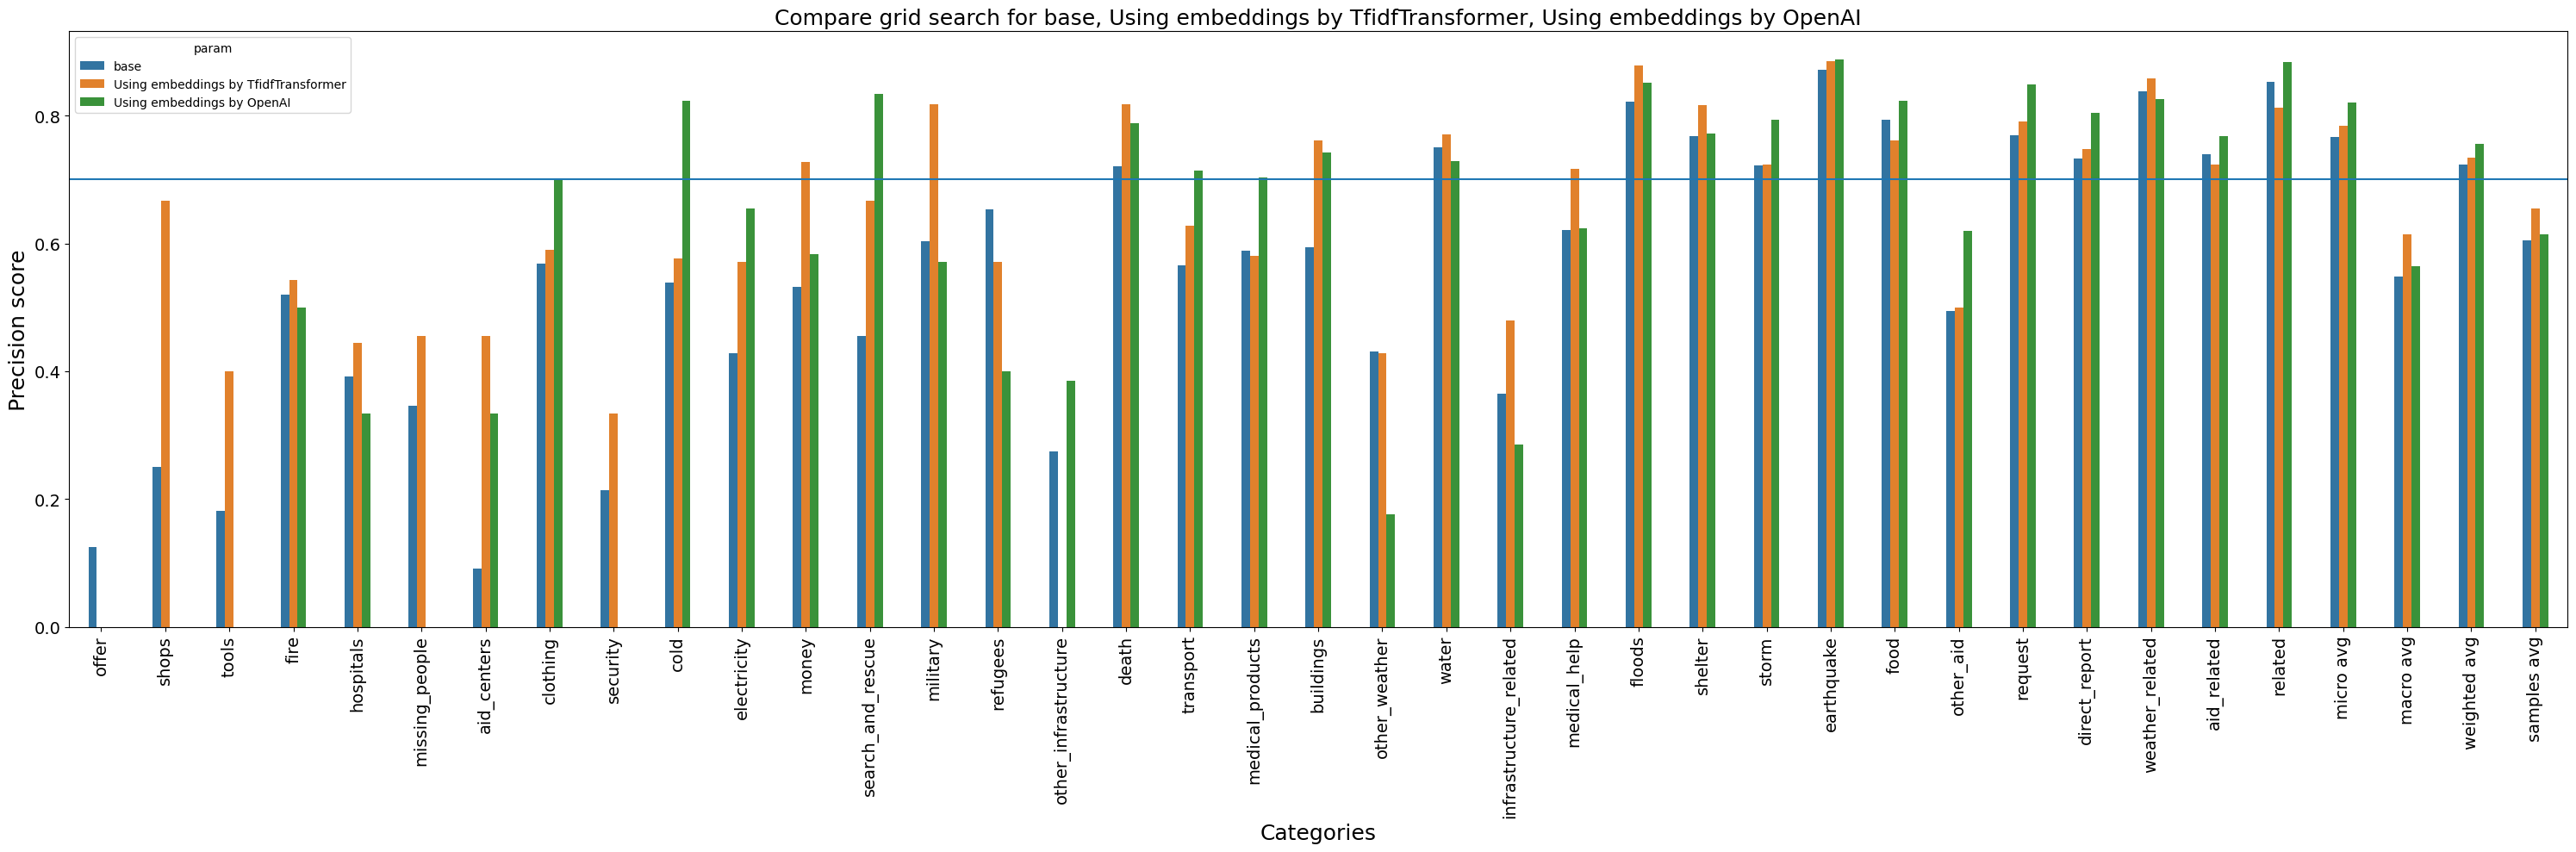

In [154]:
plot_scores(score1=score_base, 
            score2=score_verb, 
            score3=score_openai, 
            score1_name='base', 
            score2_name='Using embeddings by TfidfTransformer', 
            score3_name='Using embeddings by OpenAI', 
            order=score_index)

> OpenAI is doing excellent in general but are not performing as well for minority classes. Perhaps this will improve with further grid search.

##### A new grid search for OpenAI embedding using Optuna

In [155]:
optuna.delete_study(study_name="xgboost-study-openai", storage=config.path_database_optuna)

In [156]:
# Let's do a fresh grid search for embeddings to see if performance improves

# clear the garbage to free memory
gc.collect()

# Unique identifier of the study
study_name = "xgboost-study-openai"  

# save study to SQLite database
storage_name = config.path_database_optuna

# Propagate logs to the root logger
optuna.logging.enable_propagation()  

# Stop showing logs in sys.stderr
optuna.logging.disable_default_handler()

# Continue grid searching on existing study if it exists (same db and name)
study_optuna = optuna.create_study(sampler=TPESampler(), 
                                   direction="maximize", 
                                   study_name=study_name, 
                                   storage=storage_name, 
                                   load_if_exists=True )

logger.info("START OPTUNA OPTIMIZATION FOR OPENAI WITH STARTING VERB...")
# study_optuna.optimize(objective_openai, n_trials=60)
study_optuna.optimize(lambda trial: objective(trial, 
                                              features=X_train_sub, 
                                              labels=y_train_sub, 
                                              model=pipeline_embedding, 
                                              eval_score=scoring, 
                                              n_splits=2,
                                              random_state=random_state), 
                      n_trials=20, 
                      gc_after_trial=True) 

print("Number of finished trials: ", len(study_optuna.trials))
print("Best trial:")
trial_optuna = study_optuna.best_trial

print("  Value: {}".format(trial_optuna.value))
print("  Params: ")
for key, value in trial_optuna.params.items():
    print("    {}: {}".format(key, value))

rmtree(cachedir)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  23.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 5.7min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  20.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 5.6min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 9.2min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 9.1min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 7.5min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 7.5min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.1min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.1min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.5min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 7.6min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 7.5min
[Pipel

In [157]:
# refit the model with best hyperparameters
pipeline_embedding.set_params(**study_optuna.best_params)

# make sure parameters are set correctly
pipeline_embedding.get_params()

{'memory': '../cache',
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('starting_verb', StartingVerbExtractor(),
                                    ['message']),
                                   ('one_hot', OneHotEncoder(), ['genre']),
                                   ('embedding_to_list', ArrayToList(),
                                    'embedding')],
                     verbose_feature_names_out=False)),
  ('clf',
   XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
                 device=None, early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=make_scorer(focal_binary_cross_entropy, response_method='predict'),
                 feature_types=None, gamma=20.538653093453885,
                 grow_policy='lossguide', importance_typ...
                 interaction_constraints=None, learning_rate=0.04425933957180706,
                 m

In [158]:
# refit the model with best hyperparameters
pipeline_embedding.fit(X_train_sub, y_train_sub)
y_pred_val, score_openai = evaluate(X_val, y_val, pipeline_embedding)
auc_openai = print_results(y_val, y_pred_val)
rmtree(cachedir)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  41.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=17.0min
                        precision    recall  f1-score   support

               related       0.88      0.91      0.90      3312
               request       0.92      0.47      0.62       744
                 offer       0.00      0.00      0.00        20
           aid_related       0.78      0.64      0.71      1807
          medical_help       0.50      0.02      0.03       347
      medical_products       0.73      0.04      0.07       219
     search_and_rescue       0.00      0.00      0.00       121
              security       0.00      0.00      0.00        79
              military       0.75      0.06      0.12       143
                 water       0.89      0.14      0.25       278
                  food       0.87      0.35      0.50       486
               shelter       0.92      0.19      0.31       385
              clothing   

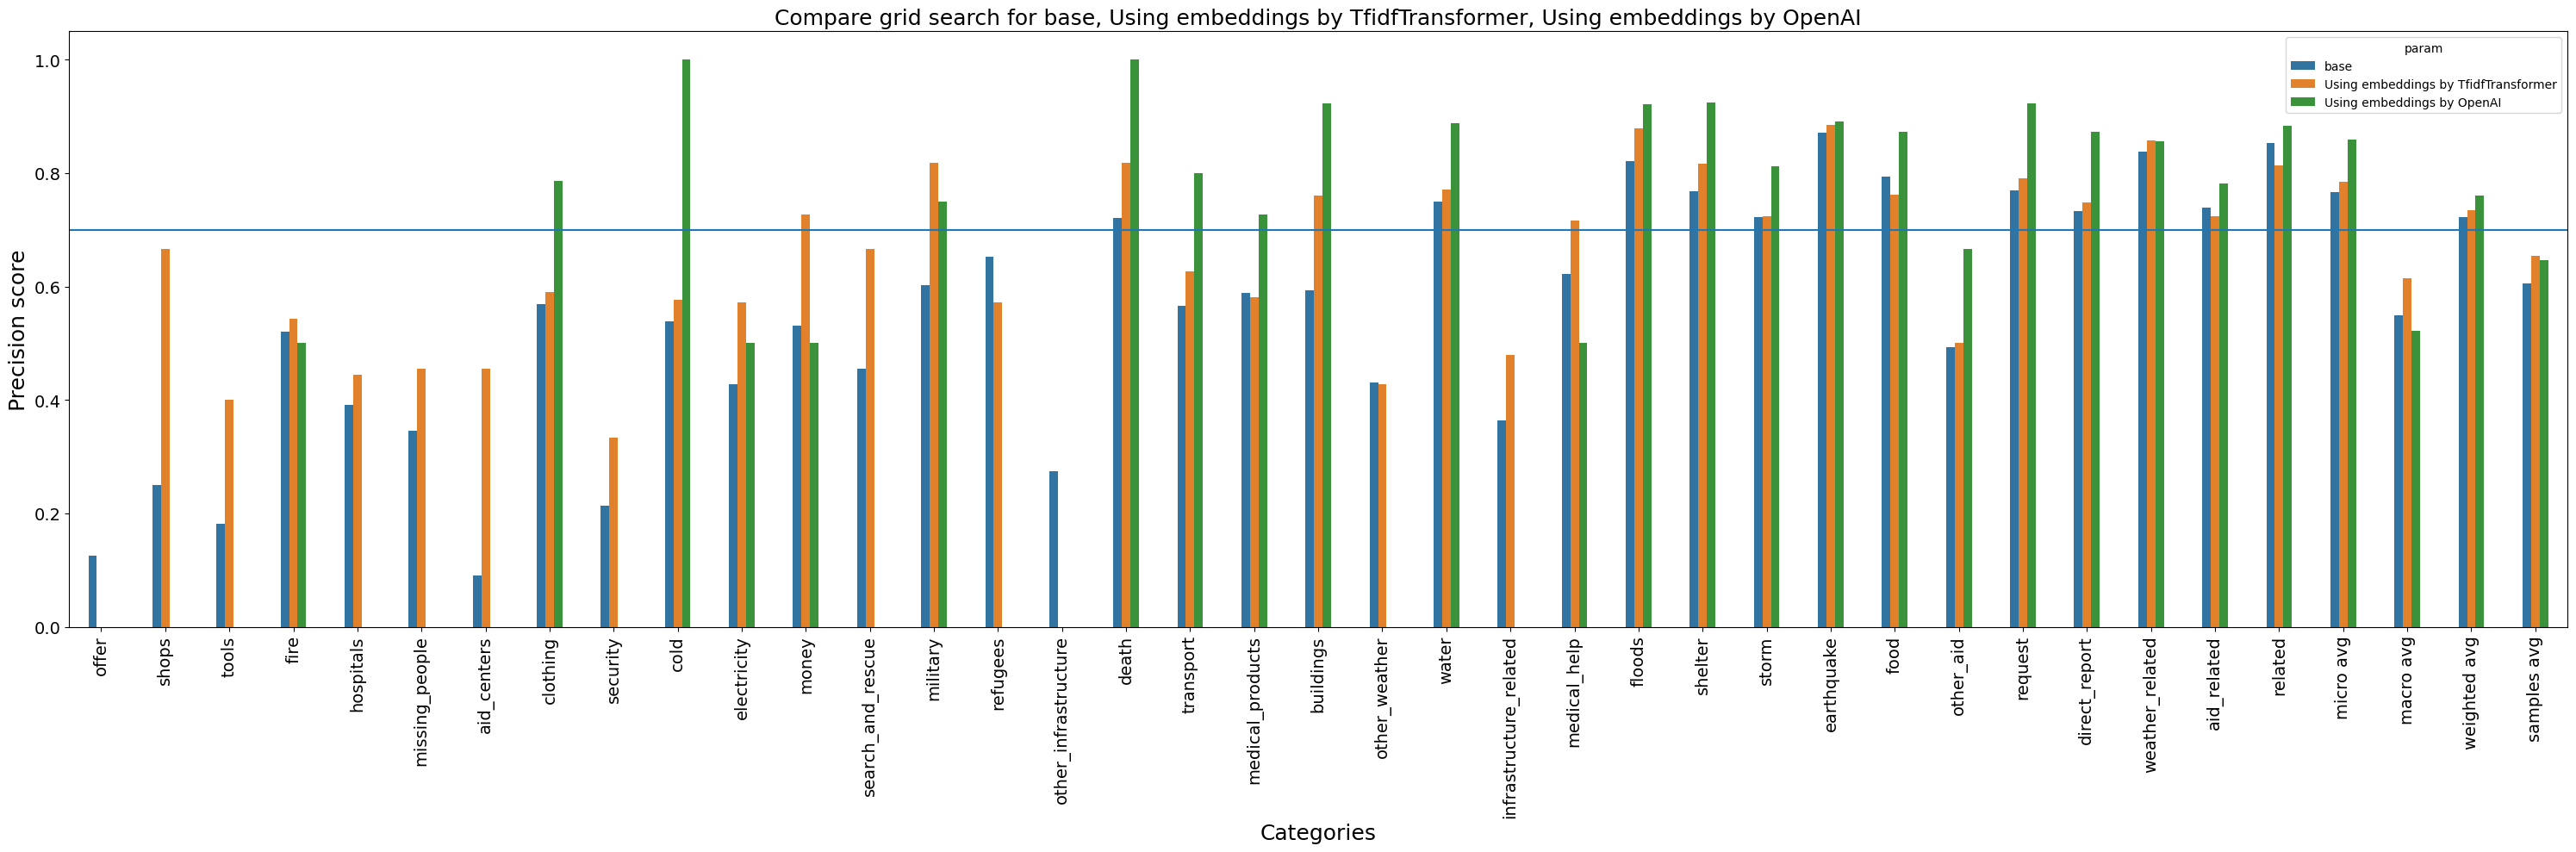

In [159]:
# Update model parameters with cross-validation results
plot_scores(score1=score_base, 
            score2=score_verb, 
            score3=score_openai, 
            score1_name='base', 
            score2_name='Using embeddings by TfidfTransformer', 
            score3_name='Using embeddings by OpenAI', 
            order=score_index)

>Conclusion: OpenAI performance is amazing, most categories shows a nuge improvement. However, it performs very badly for imbalanced datasets. There is a huge reduction in dimensions to only 3000, perhaps this effects the quality.

<a class="anchor" id='step7'></a>
<span style="color:blue; font-size:25px; line-height:40px; font-family: Calibri;">7. Final model performance</span>

In [167]:
# clear the garbage to free memory
gc.collect()

y_pred_test, score_test = evaluate(X_test, y_test, pipeline_base)
auc_test = print_results(y_test, y_pred_test)

                        precision    recall  f1-score   support

               related       0.85      0.89      0.87      3313
               request       0.86      0.38      0.53       744
                 offer       1.00      0.16      0.27        19
           aid_related       0.77      0.46      0.58      1806
          medical_help       0.89      0.07      0.13       347
      medical_products       0.79      0.27      0.41       219
     search_and_rescue       0.67      0.07      0.12       121
              security       1.00      0.03      0.05        79
              military       0.91      0.07      0.13       143
                 water       0.85      0.53      0.65       278
                  food       0.82      0.78      0.80       486
               shelter       0.83      0.54      0.66       385
              clothing       0.69      0.61      0.65        67
                 money       1.00      0.06      0.11       101
        missing_people       0.67      

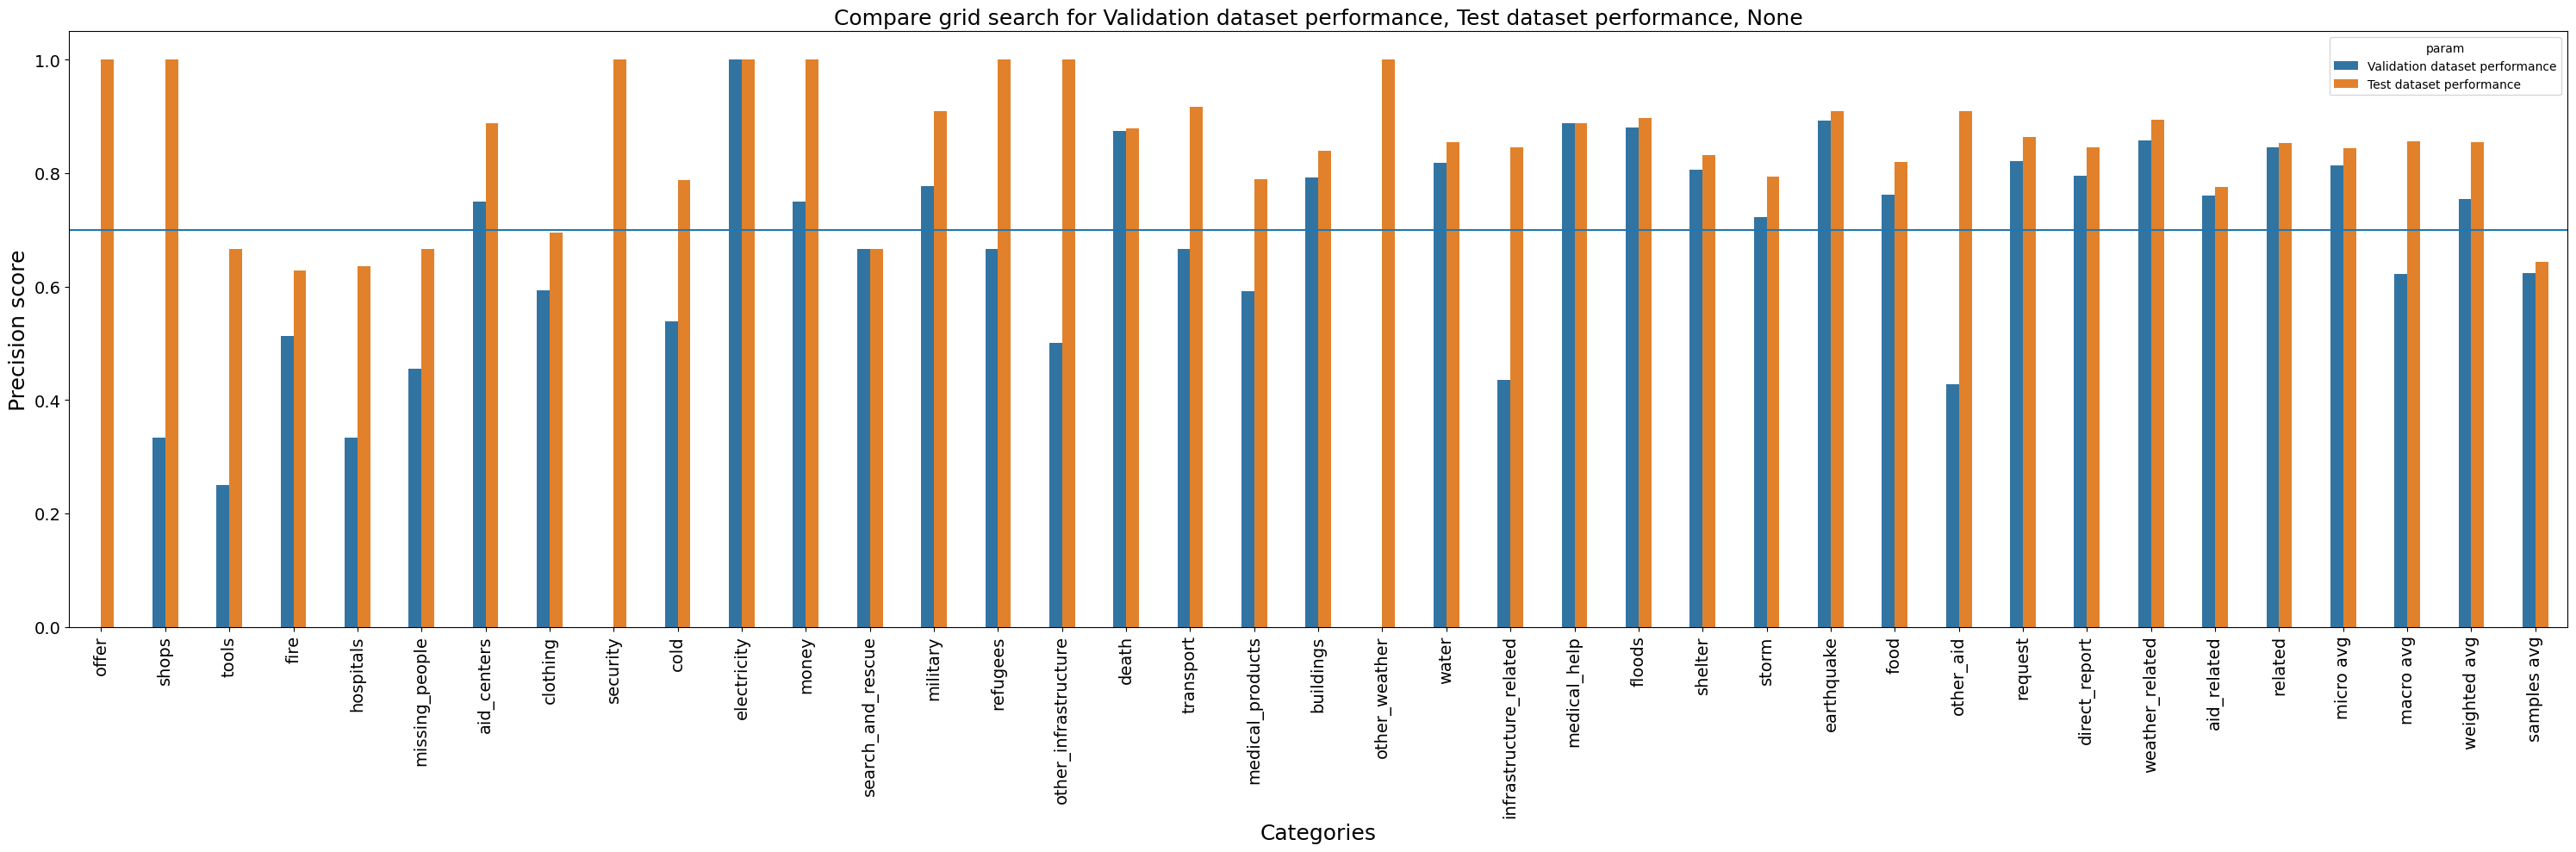

In [168]:
plot_scores(score1=score_optuna, score2=score_test, score3=None, score1_name='Validation dataset performance',
            score2_name='Test dataset performance', score3_name=None, order=score_index)

>**Conclusion:** Final model performance on test data is amazing with 0.84 micro precision and 0.86 macro performance !! Great performance on imbalanced labels.

<a class="anchor" id='step8'></a>
<span style="color:blue; font-size:25px; line-height:40px; font-family: Calibri;">8. Save fitted model</span>

In [160]:
# save the best fitted model
dump(pipeline_base, open(config.path_model_prep, 'wb'))

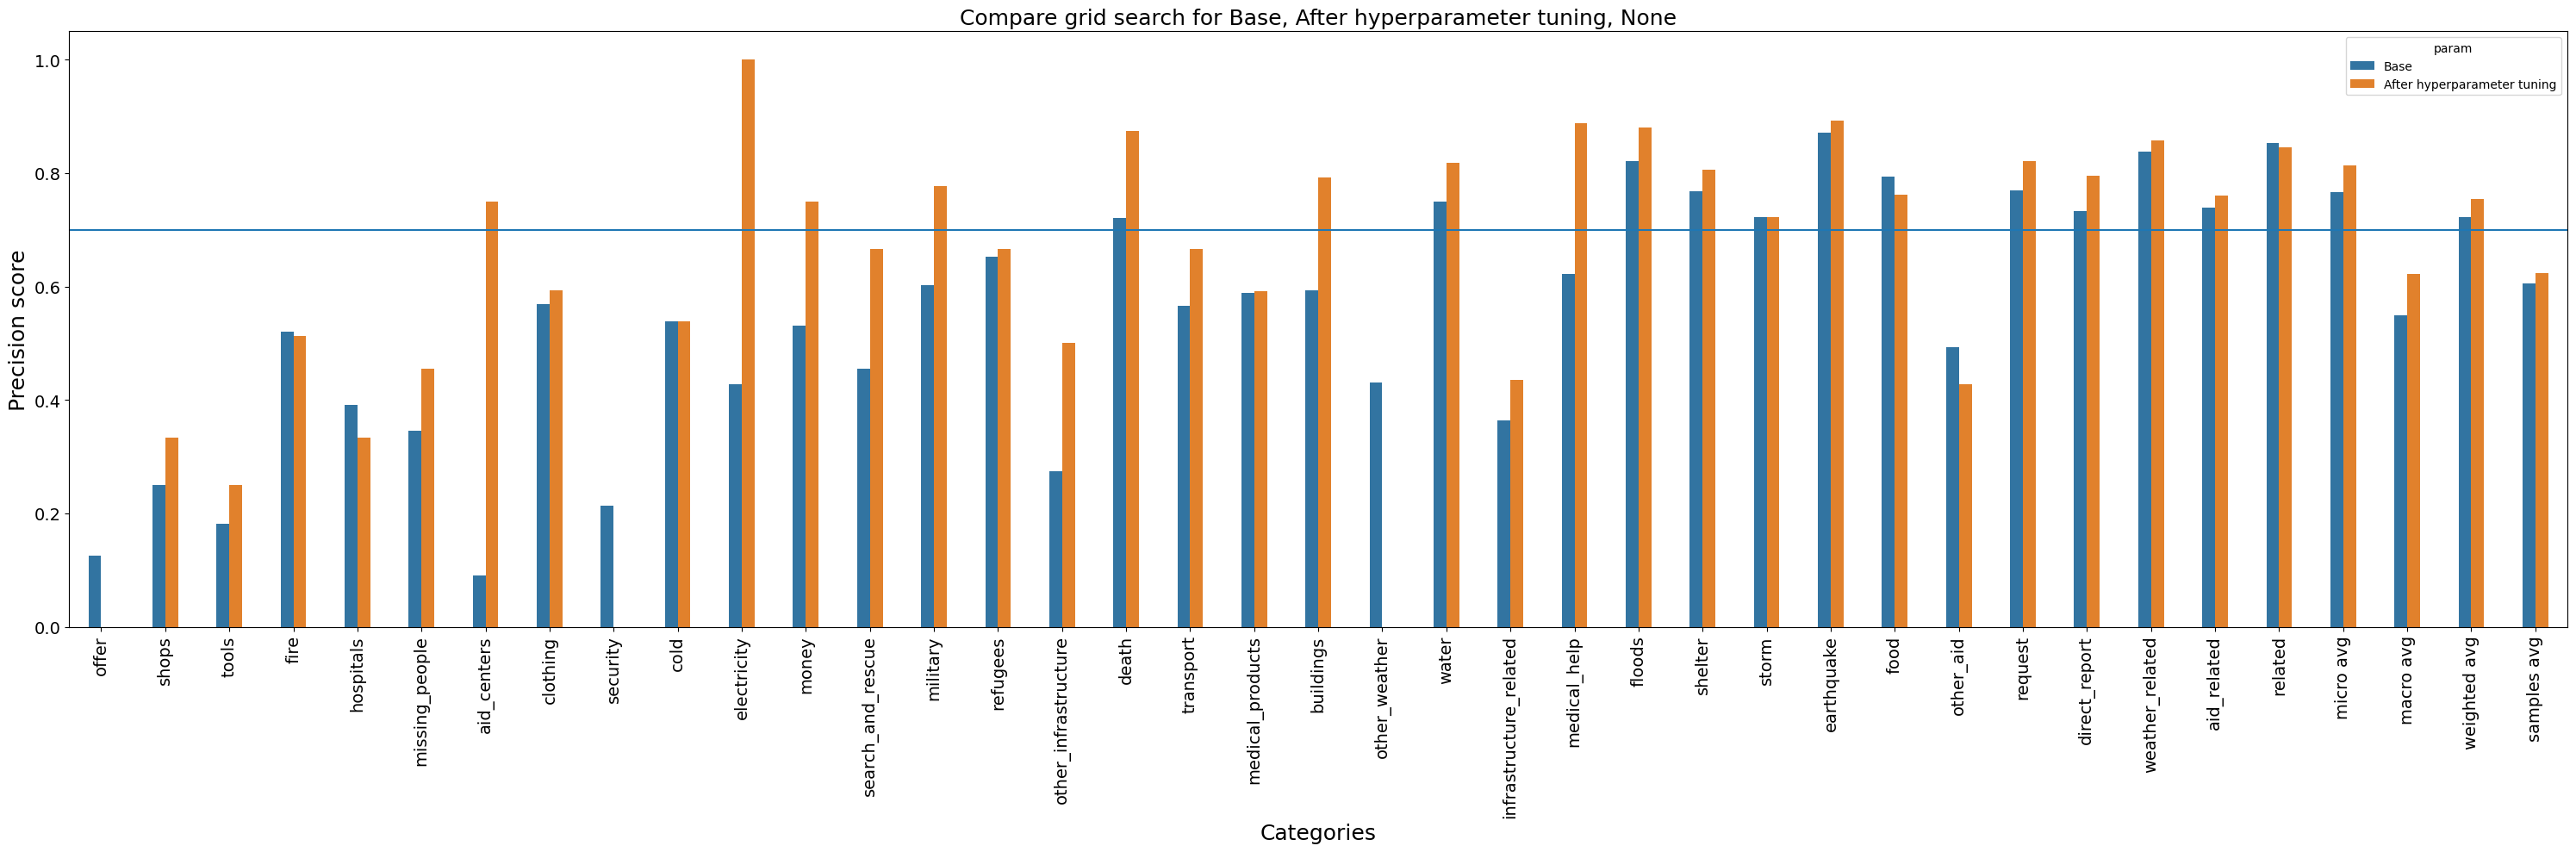

In [164]:
# Generate simpler final image for website showing model performance
plot_scores(score1=score_base, score2=score_optuna, score3=None, score1_name='Base', score2_name='After hyperparameter tuning', score3_name=None, order=score_index)

<a class="anchor" id='ref'></a>
<span style="color:blue; font-size:25px; line-height:40px; font-family: Calibri;">9. References</span>

###### XGBOOST:
- [xgboost for LLMS](https://www.kaggle.com/code/vbmokin/llm-20-feature-xgboost-after-deobfuscation/notebook)
- [How to use xgboost multi label](https://xgboost.readthedocs.io/en/latest/python/examples/multioutput_regression.html#sphx-glr-python-examples-multioutput-regression-py)
- [XGBOOST is all you need](https://www.kaggle.com/code/lucamassaron/easy-peasy-eda-xgboost-is-all-you-need/notebook)
- [Hyperparameter grid search with xgboost](https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost)
- [Mastering XGBoost Parameters Tuning](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- [XGBOOST Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#handle-imbalanced-dataset)


###### Pipelines:
- [Nested pipelines](https://gist.github.com/amberjrivera/8c5c145516f5a2e894681e16a8095b5c)


###### Grid Search:
- [Using predefined split during cross-validation](https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn)
- [Using GridSearchCV to validate against validation dataset](https://stackoverflow.com/questions/46815252/using-scikit-learn-gridsearchcv-for-cross-validation-with-predefinedsplit-susp)
- [Plotting training vs validation cross-validation scores](https://www.kaggle.com/code/willcanniford/predicting-back-pain-with-sklearn-and-gridsearchcv)
- [Early stopping](https://stackoverflow.com/questions/78178902/is-there-example-of-xgb-xgbregressor-with-callbacks-early-stop-early-stop-xgb)


###### OPTUNA:
- [Optima demo](https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py)
- [From Daily Dose of Data Science: Bayesian Optimization for Hyperparameter Tuning](https://www.dailydoseofds.com/bayesian-optimization-for-hyperparameter-tuning/)


###### Imbalance:
- [Stratification multi-label](https://videolectures.net/ecmlpkdd2011_tsoumakas_stratification/?q=stratification%20multi%20label)
- [Test/Train split for multi-label stratification](https://datascience.stackexchange.com/questions/45174/how-to-use-sklearn-train-test-split-to-stratify-data-for-multi-label-classificat)
- [Upsample with multilabel MLSMOTE](https://www.kaggle.com/code/tolgadincer/upsampling-multilabel-data-with-mlsmote)
- [Oversampling](https://www.kaggle.com/code/thedrcat/oversampling-for-multi-label-classification)
- [Creating Balanced Multi-Label Datasets for Model Training and Evaluation](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)
- [MLSMOTE for MoA](https://www.kaggle.com/code/yassinealouini/mlsmote-for-moa)
- [Creating balanced multilabel datasets comparing multiple libraries](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)
- [XGBoost and imbalanced datasets: Strategies for handling class imbalance](https://medium.com/@rithpansanga/xgboost-and-imbalanced-datasets-strategies-for-handling-class-imbalance-cdd810b3905c)


###### Evaluation:
- [Evaluation metrics for cross valdation](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001)
- [Focal loss with XGBOOST](https://www.kaggle.com/code/kriskriskris/imbalanced-data-practice)
- [precision-recall curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)
- [Focal multi-label loss](https://www.kaggle.com/code/thedrcat/focal-multilabel-loss-in-pytorch-explained)
- [Focal loss for handling the issue of class imbalance](https://medium.com/data-science-ecom-express/focal-loss-for-handling-the-issue-of-class-imbalance-be7addebd856)


###### OpenAI:
- [Open OpenAI batch processing](https://cookbook.openai.com/examples/batch_processing)


###### Text processing
- [text augmentation using SynonymAug](https://medium.com/@ka.kaewnoparat/the-power-of-stopword-removal-and-data-augmentation-for-imbalanced-classes-in-multi-label-61444ba8dacd)